Imports

In [239]:
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
import collections
%matplotlib inline

import sklearn as sk
from sklearn.neighbors import KNeighborsClassifier
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from time import time
from scipy import ndimage
from sklearn import manifold

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import operator
import pickle as pk
from sklearn.cluster import AgglomerativeClustering

from itertools import chain
import numpy.linalg as LA
from scipy.spatial.distance import pdist

In [176]:
original_dataset_digits = pd.read_csv('DatasetChampionIndices.csv')

In [295]:
with open('ChampionsAllInfo.pkl', 'rb') as inp:
    champions = pk.load(inp)
    
# champion stats normalization and preprocessing
# Standard Normalization (x-mean(x) / std(x))
STAT = True
champions_stats = []
for i in range(len(champions)):
    if STAT:
        stat = champions[i]['stats']
        champions_stats.append([stat['hp'], stat['attackdamage'], stat['armor'], stat['spellblock'], stat['movespeed'], stat['attackrange'], stat['hpregen']])
    else:
        info = champions[i]['info']
        champions_stats.append([info['attack'], info['defense'], info['difficulty'], info['magic']])
min_max_scaler = preprocessing.StandardScaler()
champions_stats_normalized = min_max_scaler.fit_transform(champions_stats)

making the dataset in 0-1 format

In [178]:
original_dataset = []
for sample in original_dataset_digits.as_matrix()[:,:-1]:
    if np.any(sample > 131) or np.any(sample < 0):
        continue
    w = np.zeros(132)
    for s in sample[:5]:
        w[int(s)] = 1
    l = np.zeros(132)
    for s in sample[5:]:
        l[int(s)] = 1
    original_dataset.append(np.hstack((w,l)))

In [179]:
dataset = pd.DataFrame(original_dataset)
dataset = dataset.sample(n=10000, replace=False)

In [180]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,254,255,256,257,258,259,260,261,262,263
14118,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6825,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16452,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15083,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Champion counts chosen by winners and losers

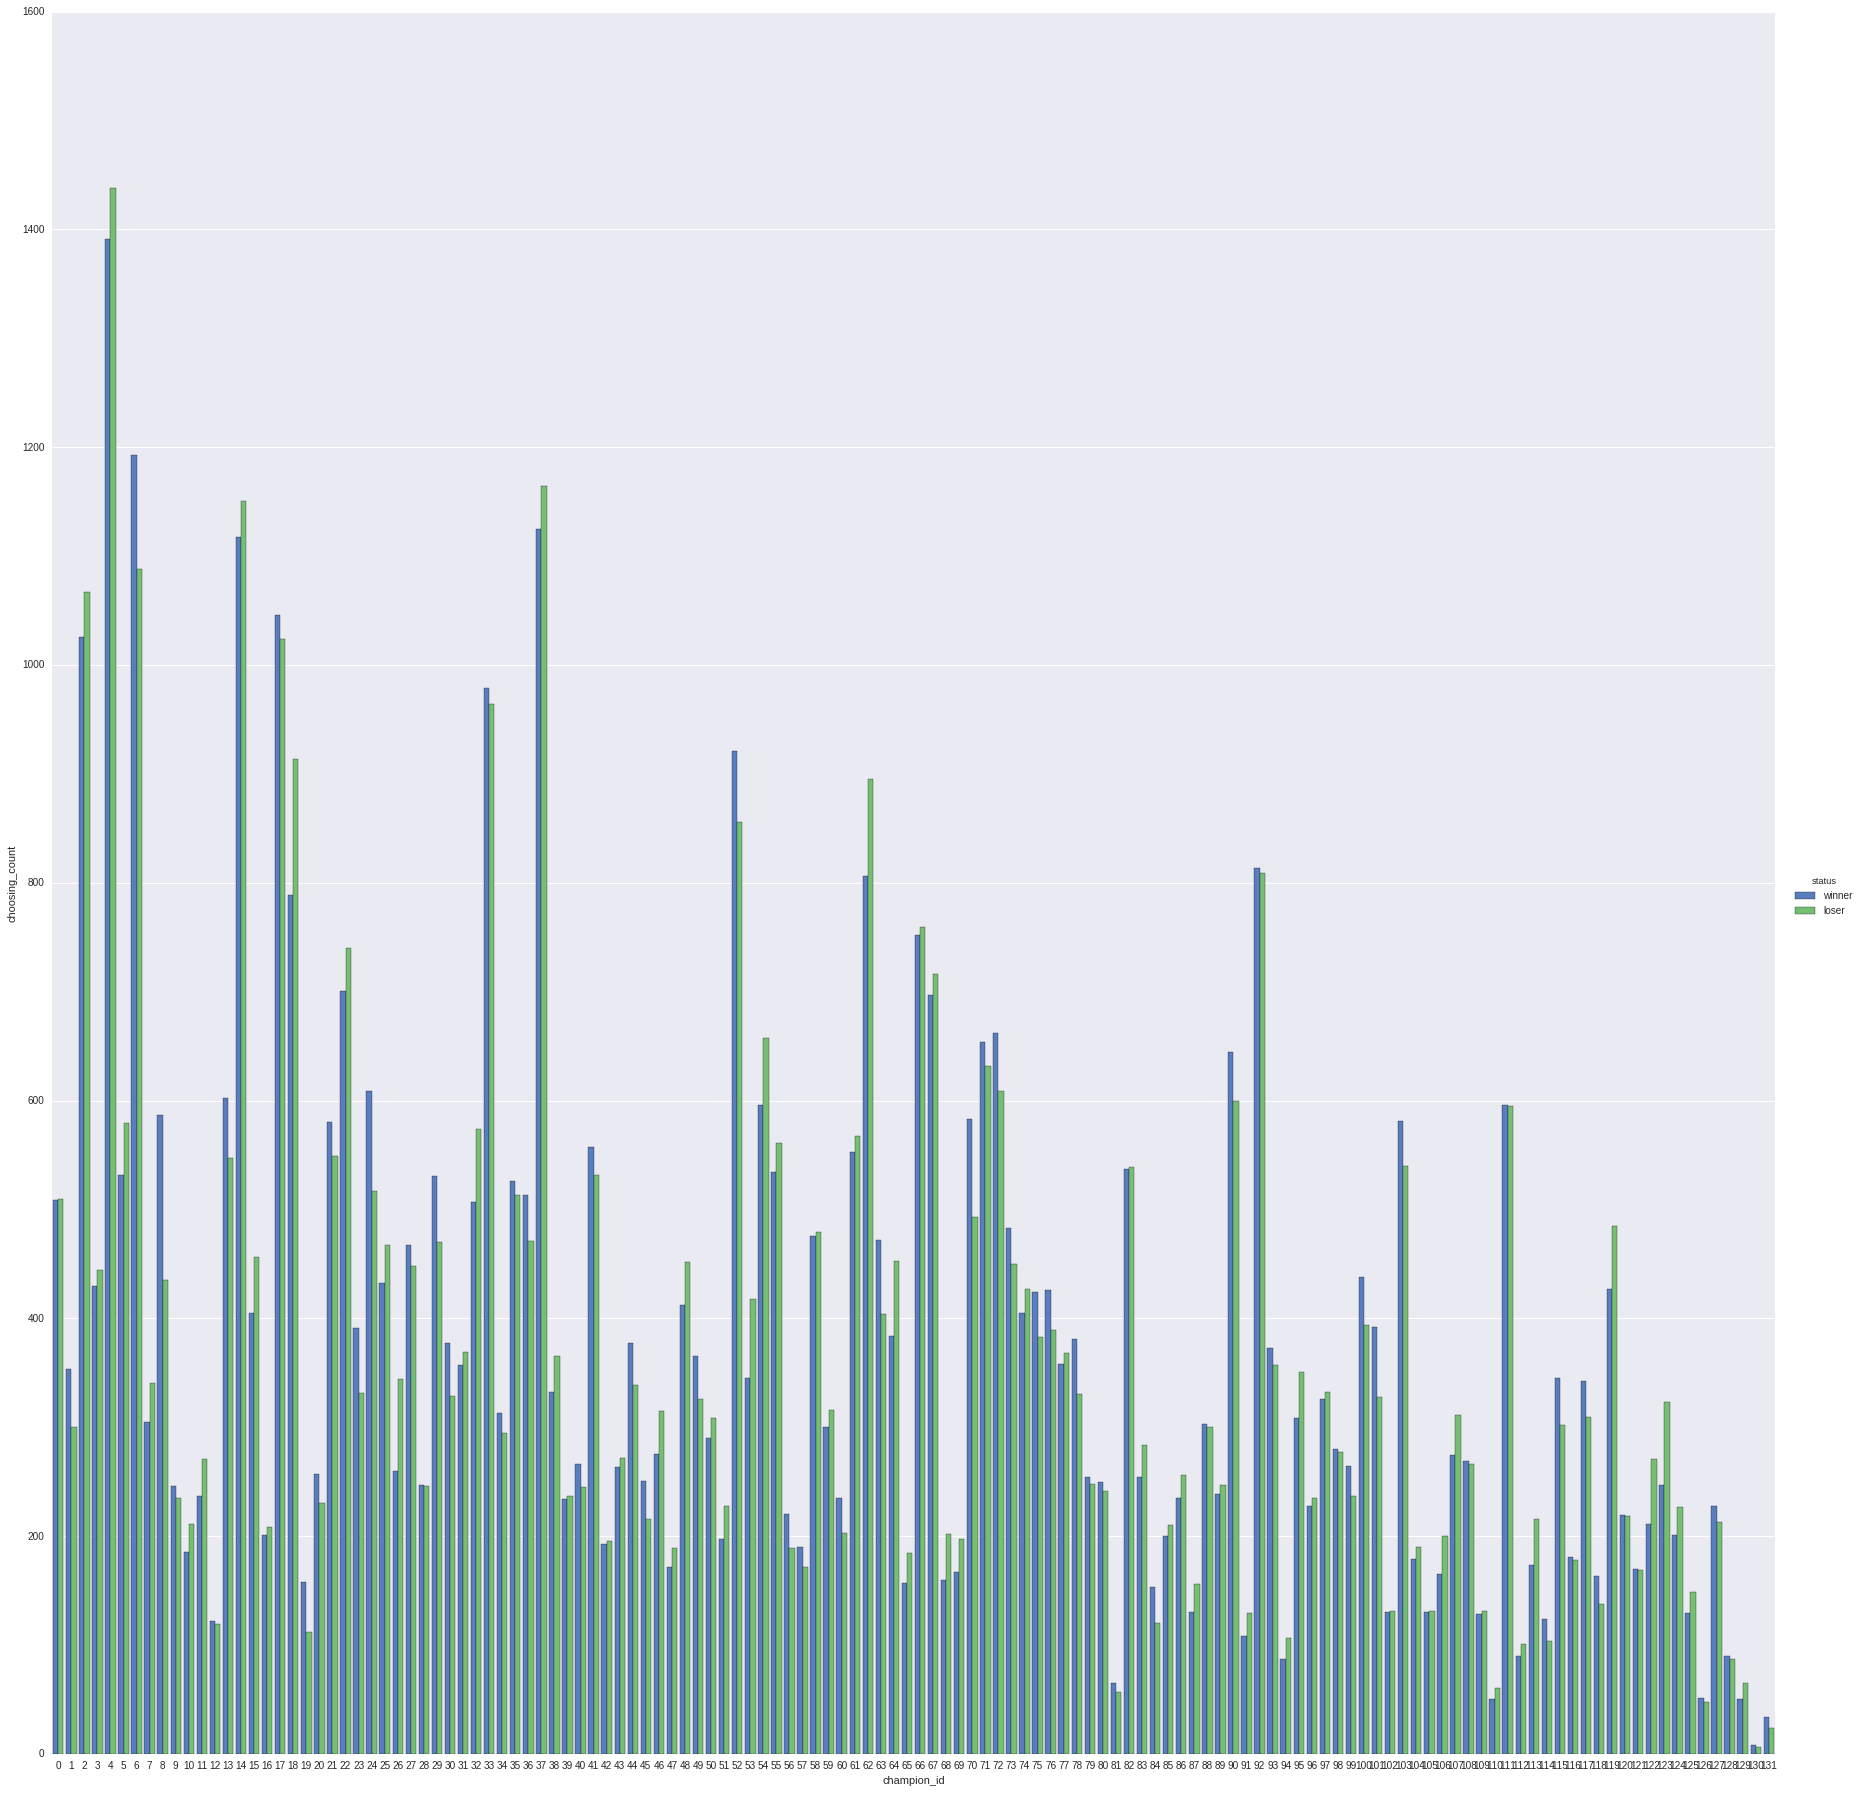

In [181]:
all_winners = dataset.ix[:,:131].as_matrix()
all_losers = dataset.ix[:,132:].as_matrix()
all_counts = []
for i in range(132):
    all_counts.append([i, len(np.where(all_winners[:,i]==1)[0]), 'winner'])
for i in range(132):
    all_counts.append([i, len(np.where(all_losers[:,i]==1)[0]), 'loser'])
dt = pd.DataFrame(all_counts, columns=['champion_id', 'choosing_count', 'status'])

g = sns.factorplot(x="champion_id", y="choosing_count", hue="status", data=dt,
                   size=25, kind="bar", palette="muted")

Adding label and swapping 50% of winners and losers
;Thus:

label 0 == winner + loser

label 1 == loser + winner

In [182]:
dataset['label'] = np.zeros([len(dataset),1])
dt = dataset.as_matrix()
idx = np.random.choice(len(dt), int(len(dt)/2), replace=False)
tf = math.floor(dt.shape[1]/2)
tmp = dt[idx,tf:2*tf]
dt[idx,tf:2*tf] = dt[idx,:tf]
dt[idx,:tf] = tmp
dt[idx,-1] = 1

In [183]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,255,256,257,258,259,260,261,262,263,label
14118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16452,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
15083,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [184]:
dataset.to_csv('BinaryChampionDataset.csv')

In [10]:
# %load plot_data.py
# Omid55
def plot_data(data):
	import numpy as np
	from sklearn.manifold import TSNE
	from sklearn.decomposition import PCA

	LIMIT = 4000
	if data.shape[0] > LIMIT:
		dt = data.sample(n=LIMIT, replace=False)
		X = dt.ix[:,:-1]
		labels = dt.ix[:,-1]
	else:
		X = data.ix[:,:-1]
		labels = data.ix[:,-1]

	tsne_model = TSNE(n_components=2, random_state=0)
	np.set_printoptions(suppress=True)
	points1 = tsne_model.fit_transform(X)
	df1 = pd.DataFrame(data=np.column_stack([points1,labels]), columns=["x","y","class"])
	sns.lmplot("x", "y", data=df1, hue='class', fit_reg=False, palette=sns.color_palette('colorblind'))
	sns.plt.title('TNSE')

	pca = PCA(n_components=2)
	pca.fit(X)
	points2 = pca.transform(X)
	df2 = pd.DataFrame(data=np.column_stack([points2,labels]), columns=["x","y","class"])
	sns.lmplot("x", "y", data=df2, hue='class', fit_reg=False, palette=sns.color_palette('colorblind'))
	sns.plt.title('PCA')



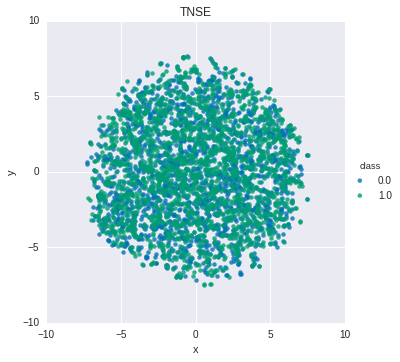

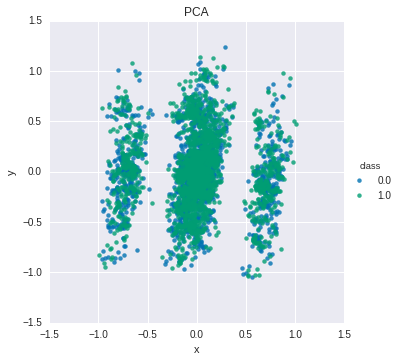

In [11]:
plot_data(dataset)

Now dataset is ready for classification

In [14]:
# %load do_classification.py
#Omid55
def do_classification(dataset, verbose=True):
    
    if type(dataset) is pd.core.frame.DataFrame:
        dataset = dataset.as_matrix()

    #clf = MLPClassifier(algorithm='l-bfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
    models = [(SGDClassifier(), 'Stochastic Gradient Descent Classifier'),
        (LogisticRegression(), 'Logistic Regression'),
        (GaussianNB(), 'Naive Bayes'),
        (svm.LinearSVC(C=1.0, verbose=False), 'Linear SVM'),
        (svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False), 'SVM with RBF kernel'),
        (RandomForestClassifier(n_estimators=100), 'Random Forest'),
        (KNeighborsClassifier(n_neighbors=8), 'KNN'),
        (DecisionTreeClassifier(max_depth=5), 'Decision Tree'),
        (AdaBoostClassifier(), 'AdaBoost'),
        (LinearDiscriminantAnalysis(), 'Linear Discriminant Analysis'),
        (QuadraticDiscriminantAnalysis(), 'Quadratic Discriminant Analysis')]
    
    # applying the models
    n_folds = 10
    k_fold = cross_validation.KFold(n=len(dataset), n_folds=n_folds, shuffle=False, random_state=None)
    accuracy = {}
    for train_index, test_index in k_fold:
        X_train = dataset[train_index,:-1]
        y_train = dataset[train_index,-1]
        X_test = dataset[test_index,:-1]
        y_test = dataset[test_index,-1]

        for clf, name in models:
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            accuracy_percent = 100 * sk.metrics.accuracy_score(y_test, y_pred) / n_folds
            if name not in accuracy:
                accuracy[name] = accuracy_percent
            else:
                accuracy[name] += accuracy_percent
    if verbose:
        for key, value in accuracy.items():
            print(key, ':', round(value,2))
    return accuracy


Hierarchical clustering

In [15]:
# %load visualize_hierarchical_clusters.py
# Omid55
def visualize_hierarchical_clusters(data, NUMBER_OF_CLUSTERS):
    X = np.asmatrix(data.ix[:,:-1])
    y = np.asanyarray(data['label'])
    
    #----------------------------------------------------------------------
    # Visualize the clustering
    def plot_clustering(X_red, X, labels, title=None):
        x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
        X_red = (X_red - x_min) / (x_max - x_min)

        plt.figure(figsize=(6, 4))
        for i in range(X_red.shape[0]):
            plt.text(X_red[i, 0], X_red[i, 1], str(y[i]),
                     color=plt.cm.spectral(labels[i] / 10.),
                     fontdict={'weight': 'bold', 'size': 9})

        plt.xticks([])
        plt.yticks([])
        if title is not None:
            plt.title(title, size=17)
        plt.axis('off')
        plt.tight_layout()

    #----------------------------------------------------------------------
    # 2D embedding of the digits dataset
    print("Computing embedding")
    X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
    print("Done.")

    from sklearn.cluster import AgglomerativeClustering

    for linkage in ('ward', 'average', 'complete'):
        clustering = AgglomerativeClustering(linkage=linkage, n_clusters=NUMBER_OF_CLUSTERS)
        t0 = time()
        clustering.fit(X_red)
        print("%s : %.2fs" % (linkage, time() - t0))
        plot_clustering(X_red, X, clustering.labels_, "%s linkage" % linkage)

    plt.show()

In [16]:
dataset_sampled = dataset.sample(n=4000, replace=False)

# Clustering Visualization

Computing embedding
Done.
ward : 17.24s
average : 18.65s
complete : 16.98s


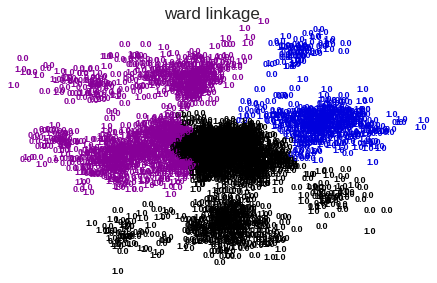

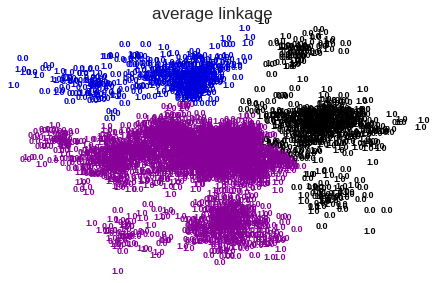

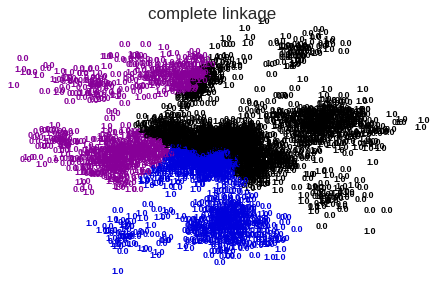

In [17]:
visualize_hierarchical_clusters(dataset_sampled, 3)

Computing embedding
Done.
ward : 17.59s
average : 17.93s
complete : 17.31s


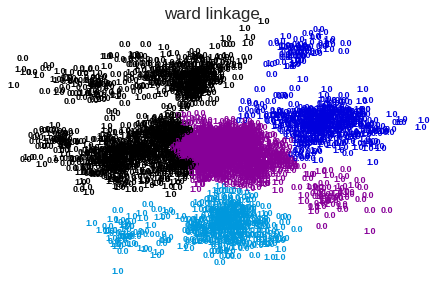

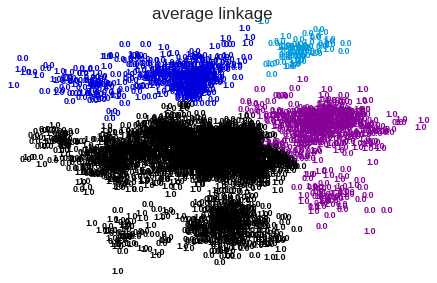

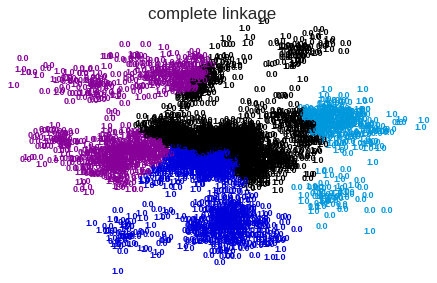

In [18]:
visualize_hierarchical_clusters(dataset_sampled, 4)

Computing embedding
Done.
ward : 17.48s
average : 17.74s
complete : 17.20s


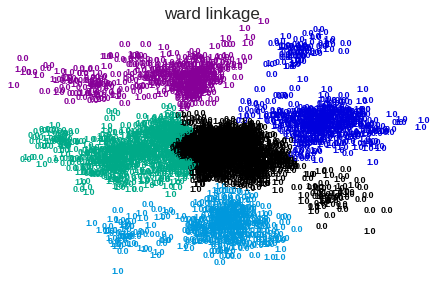

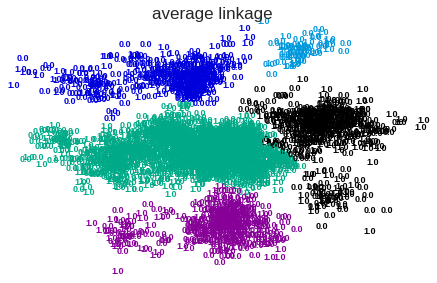

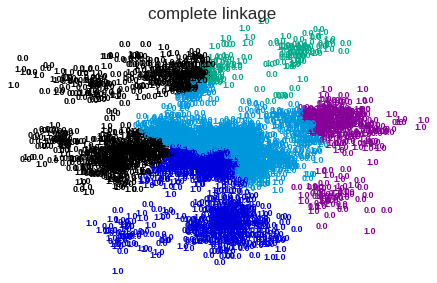

In [19]:
visualize_hierarchical_clusters(dataset_sampled, 5)

Computing embedding
Done.
ward : 16.67s
average : 17.09s
complete : 16.73s


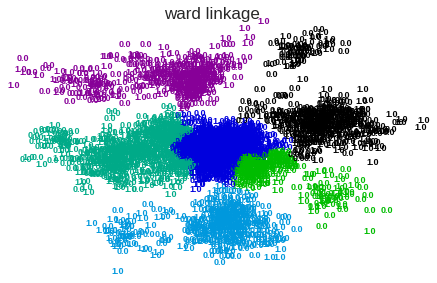

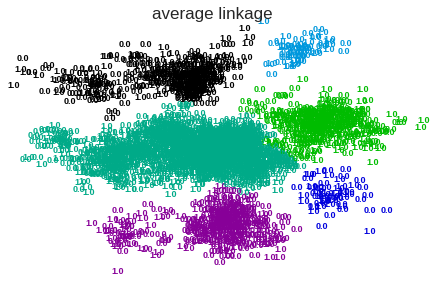

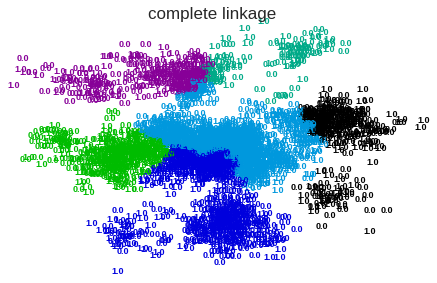

In [20]:
visualize_hierarchical_clusters(dataset_sampled, 6)

Computing embedding
Done.
ward : 17.06s
average : 17.89s
complete : 16.74s


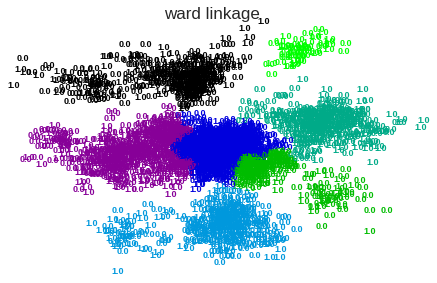

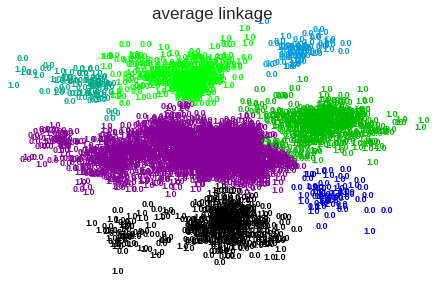

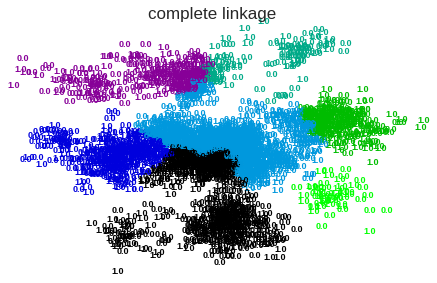

In [21]:
visualize_hierarchical_clusters(dataset_sampled, 7)

Computing embedding
Done.
ward : 16.71s
average : 17.19s
complete : 16.72s


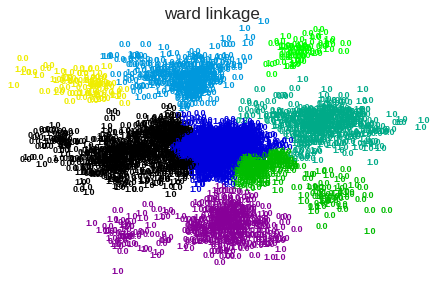

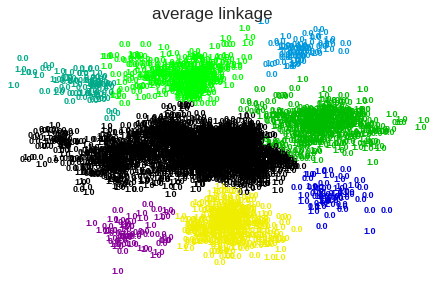

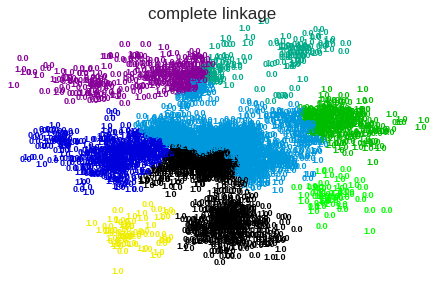

In [22]:
visualize_hierarchical_clusters(dataset_sampled, 8)

Computing embedding
Done.
ward : 17.19s
average : 17.23s
complete : 16.72s


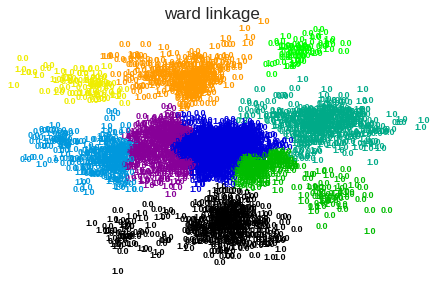

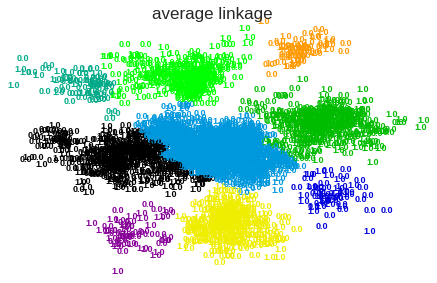

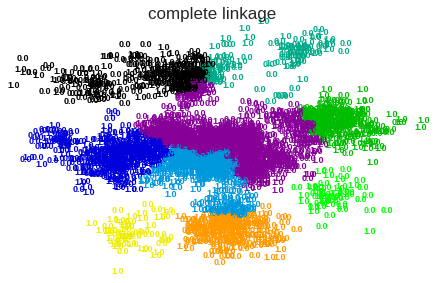

In [23]:
visualize_hierarchical_clusters(dataset_sampled, 9)

In [26]:
import warnings
warnings.filterwarnings('ignore')

print('Classification on whole dataset:')
acc = do_classification(dataset_sampled)

Classification on whole dataset:
KNN : 49.5
Linear SVM : 50.75
Stochastic Gradient Descent Classifier : 50.5
Random Forest : 50.05
Linear Discriminant Analysis : 50.75
Naive Bayes : 50.97
Decision Tree : 50.3
Quadratic Discriminant Analysis : 50.45
Logistic Regression : 50.88
AdaBoost : 49.65
SVM with RBF kernel : 49.78


In [31]:
NUMBER_OF_CLUSTERS = 9
just_print_the_best = True

X = np.asmatrix(dataset_sampled.ix[:,:-1])
y = np.asanyarray(dataset_sampled['label'])
for linkage in ('ward', 'average', 'complete'):
    accuracies = collections.defaultdict(lambda: 0)
    print('Linkage is', linkage, '=>\n\n')
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=NUMBER_OF_CLUSTERS)
    clustering.fit(X)
    for cluster_index in range(NUMBER_OF_CLUSTERS):
        idx = np.where(clustering.labels_==cluster_index)[0]
        print('Length of this cluster is:', len(idx),'\n')
        if len(idx) > 20:
            if just_print_the_best:
                accuracy = do_classification(np.column_stack((X[idx,:], y[idx])), verbose=False)
                print(max(accuracy.items(), key=operator.itemgetter(1)))
            else:
                accuracy = do_classification(np.column_stack((X[idx,:], y[idx])), verbose=True)
            print('\n----------------------------------------------\n')
    print('\n\n\n================================================')

Linkage is ward =>


Length of this cluster is: 2055 

('Quadratic Discriminant Analysis', 51.63390954297892)

----------------------------------------------

Length of this cluster is: 351 

('Naive Bayes', 52.412698412698418)

----------------------------------------------

Length of this cluster is: 345 

('Naive Bayes', 55.075630252100851)

----------------------------------------------

Length of this cluster is: 220 

('Naive Bayes', 52.27272727272728)

----------------------------------------------

Length of this cluster is: 194 

('KNN', 60.368421052631575)

----------------------------------------------

Length of this cluster is: 188 

('Linear SVM', 52.748538011695906)

----------------------------------------------

Length of this cluster is: 233 

('SVM with RBF kernel', 56.612318840579711)

----------------------------------------------

Length of this cluster is: 203 

('SVM with RBF kernel', 53.61904761904762)

----------------------------------------------

Length of 

In [27]:
def print_one_cluster_champions(clustering, cluster_label):
    idx = np.where(clustering.labels_==cluster_label)[0]
    print('Length of this cluster is:', len(idx))
    cluster8 = np.column_stack((X[idx,:], y[idx]))

    winners = np.vstack((cluster8[np.where(cluster8[:,-1] == 1)[0],:132], cluster8[np.where(cluster8[:,-1] == 0)[0],132:-1]))
    losers = np.vstack((cluster8[np.where(cluster8[:,-1] == 1)[0],132:-1], cluster8[np.where(cluster8[:,-1] == 0)[0],:132]))

    counts = []
    for i in range(132):
        counts.append([i, len(np.where(winners[:,i]==1)[0]), 'winner'])
    for i in range(132):
        counts.append([i, len(np.where(losers[:,i]==1)[0]), 'loser'])
    dt = pd.DataFrame(counts, columns=['champion_id', 'choosing_count', 'status'])
    g = sns.factorplot(x="champion_id", y="choosing_count", hue="status", data=dt,
                       size=25, kind="bar", palette="muted")
    g.fig.show()

In [53]:
clustering = AgglomerativeClustering(linkage='average', n_clusters=NUMBER_OF_CLUSTERS)
clustering.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average',
            memory=Memory(cachedir=None), n_clusters=9, n_components=None,
            pooling_func=<function mean at 0x7fd72c0f98c8>)

Length of this cluster is: 1274
Length of this cluster is: 168
Length of this cluster is: 1307
Length of this cluster is: 584
Length of this cluster is: 33
Length of this cluster is: 19
Length of this cluster is: 543
Length of this cluster is: 18
Length of this cluster is: 54


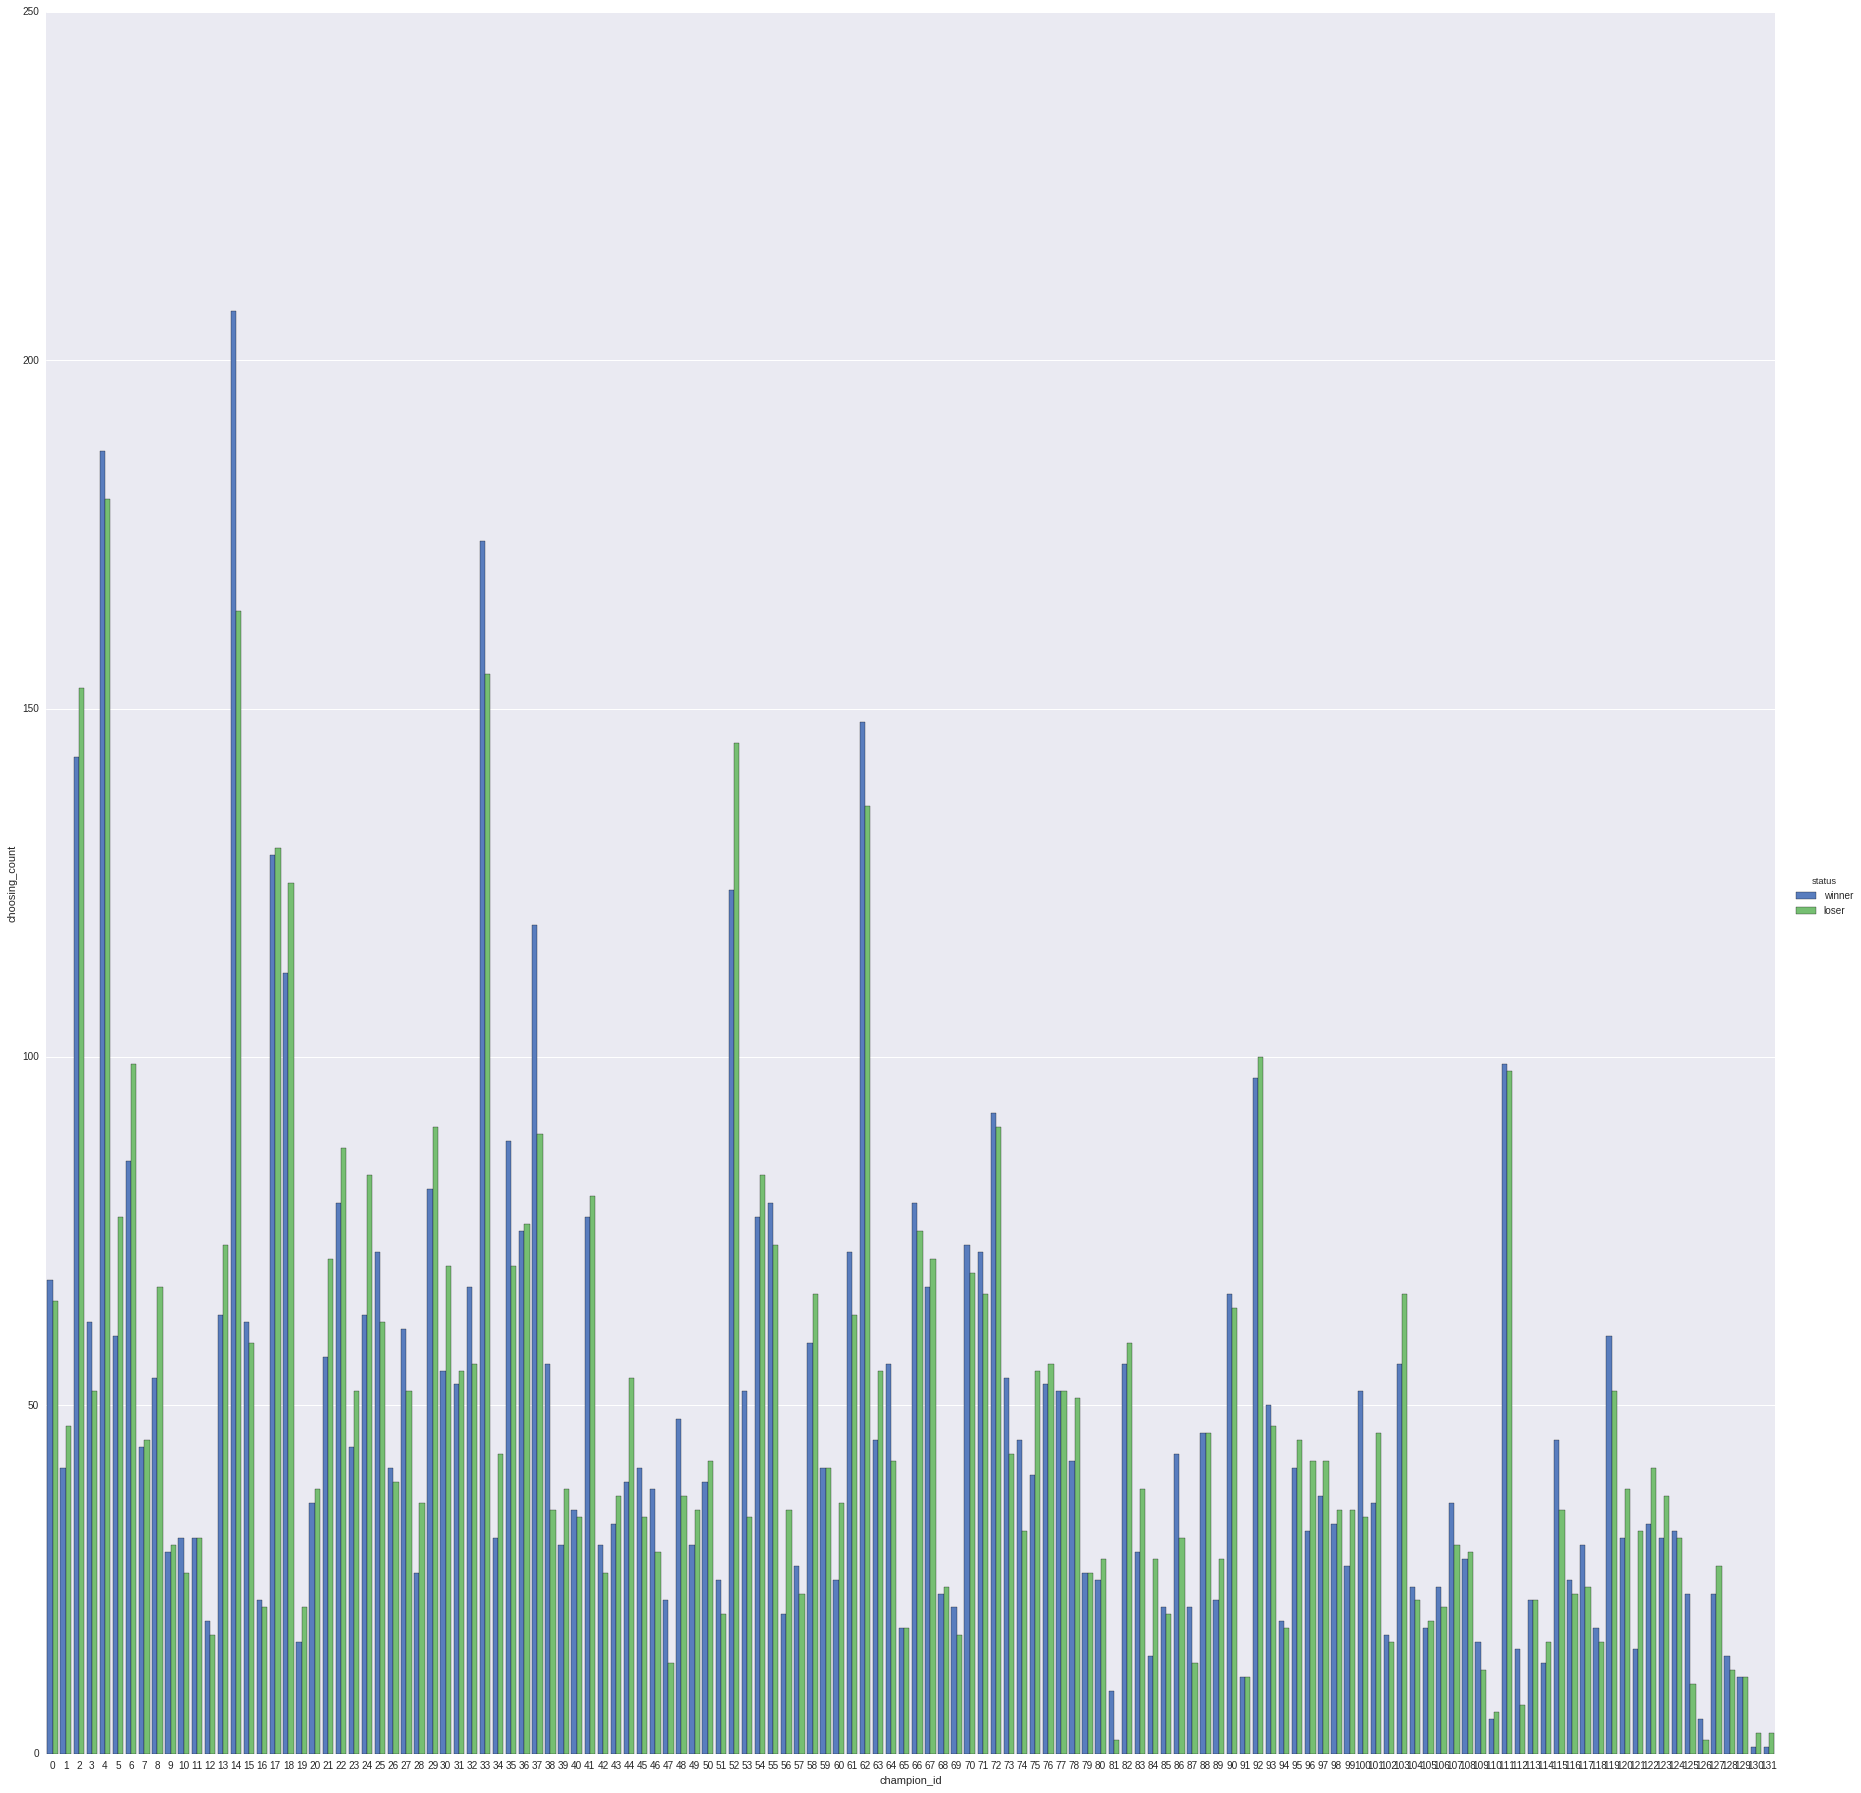

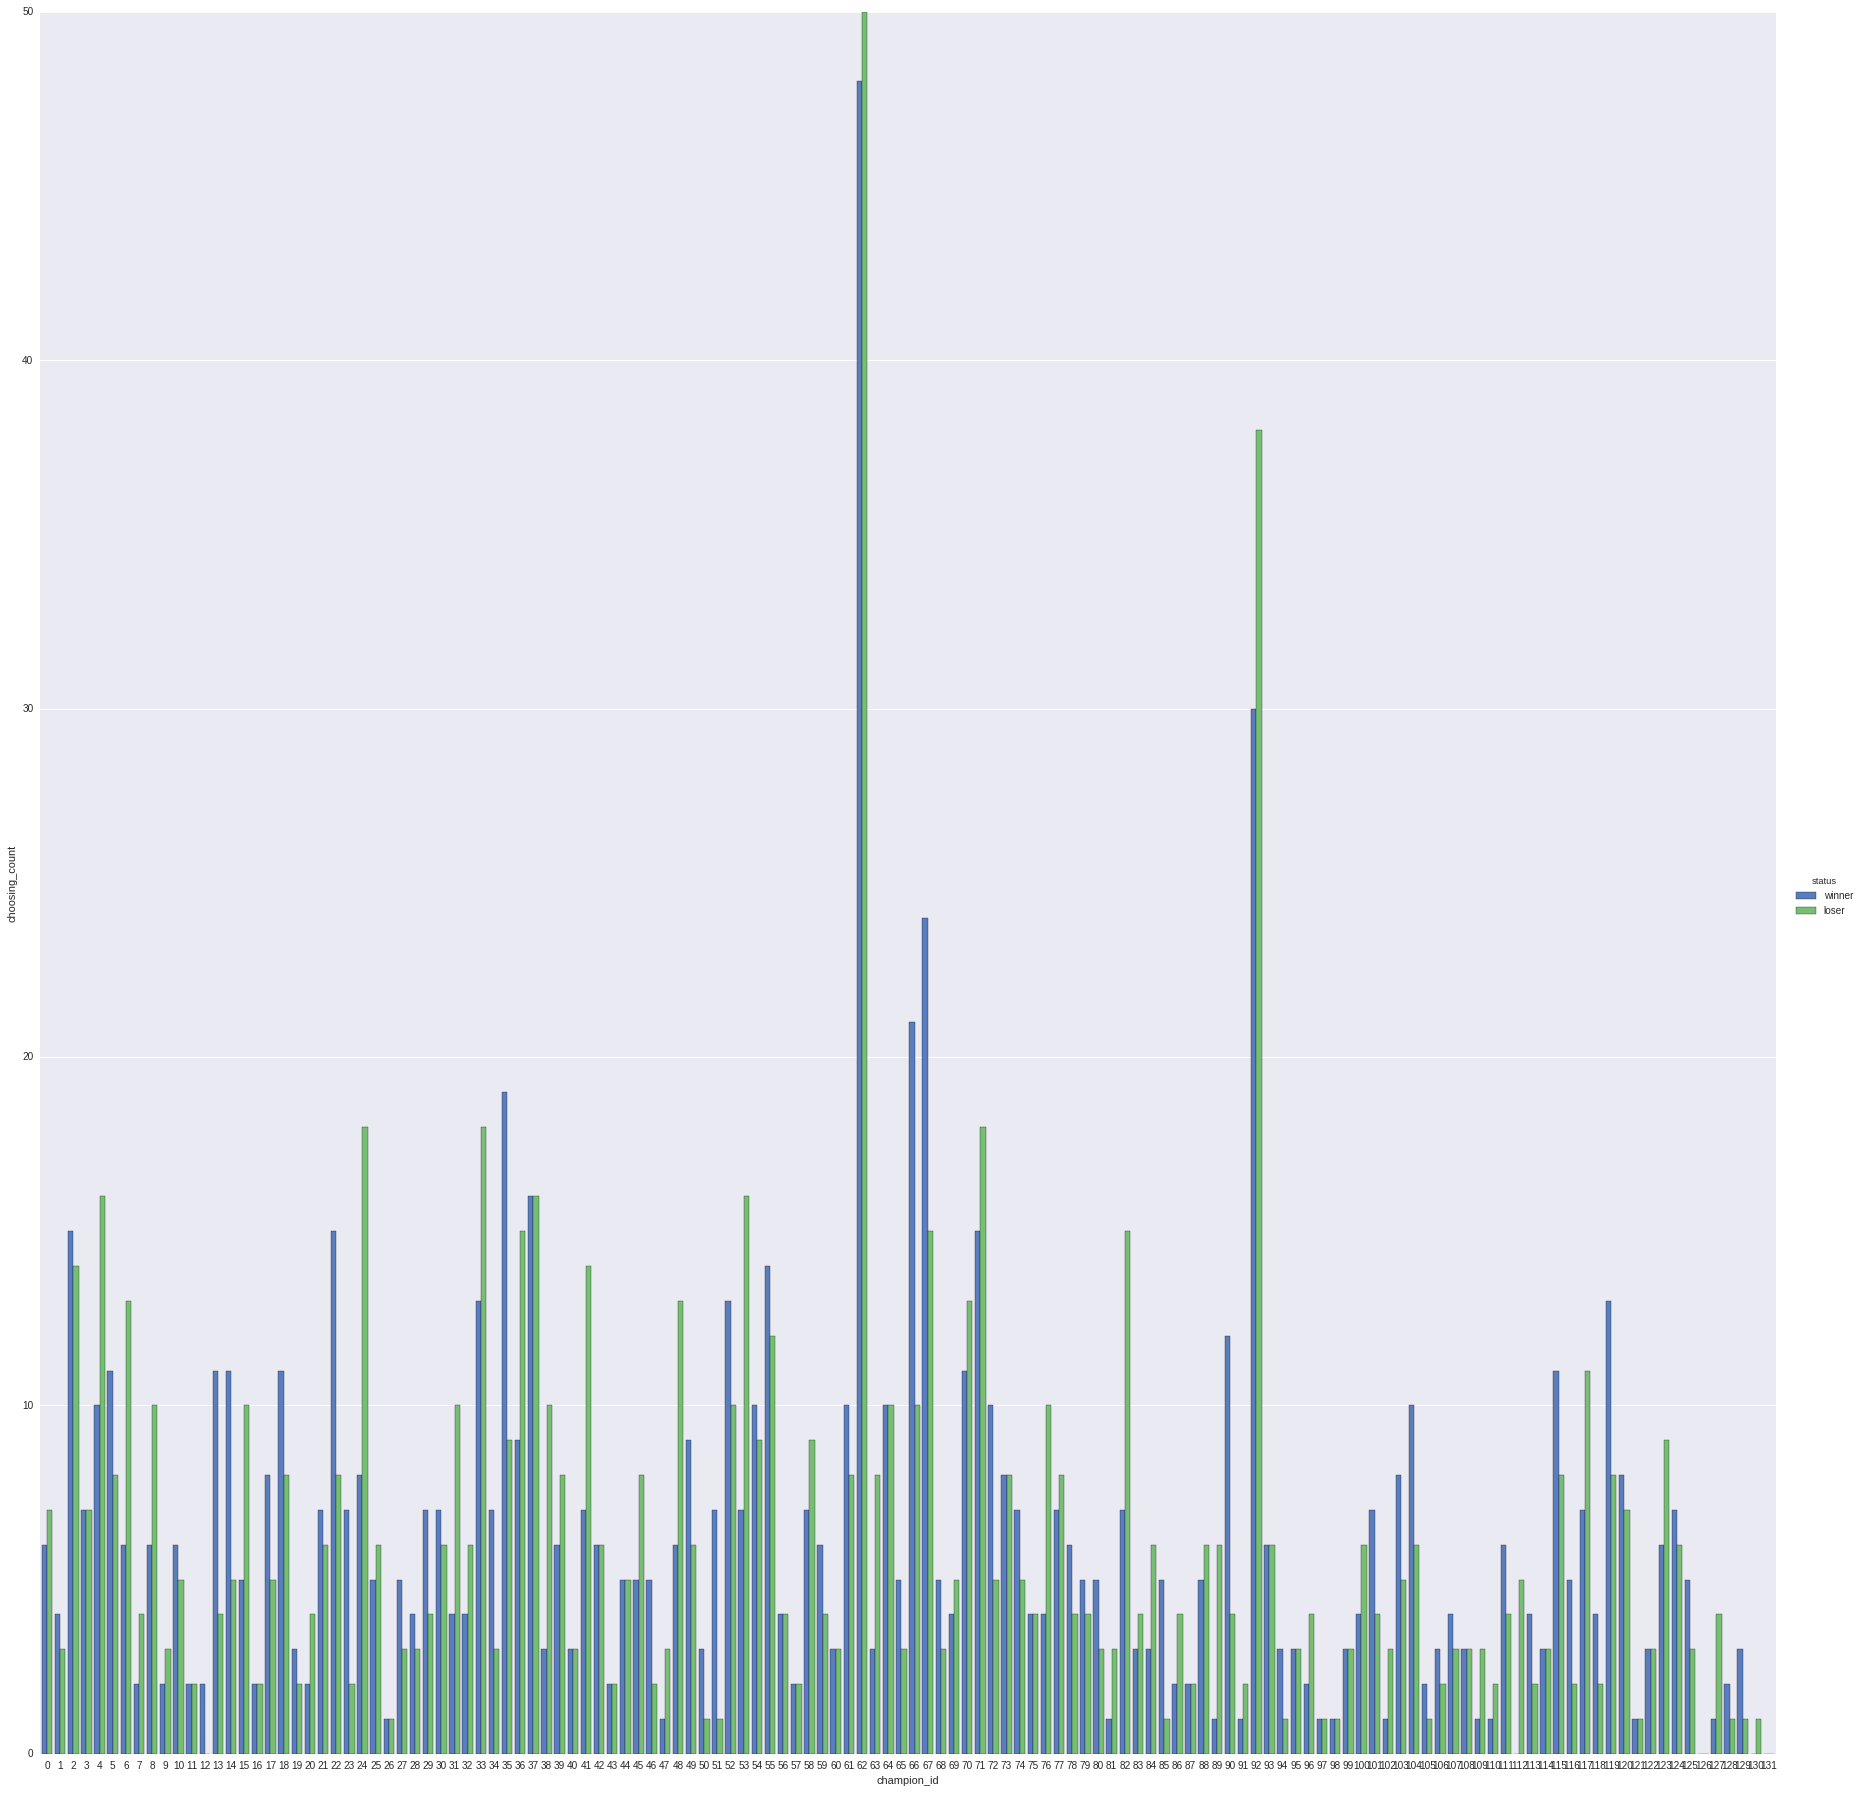

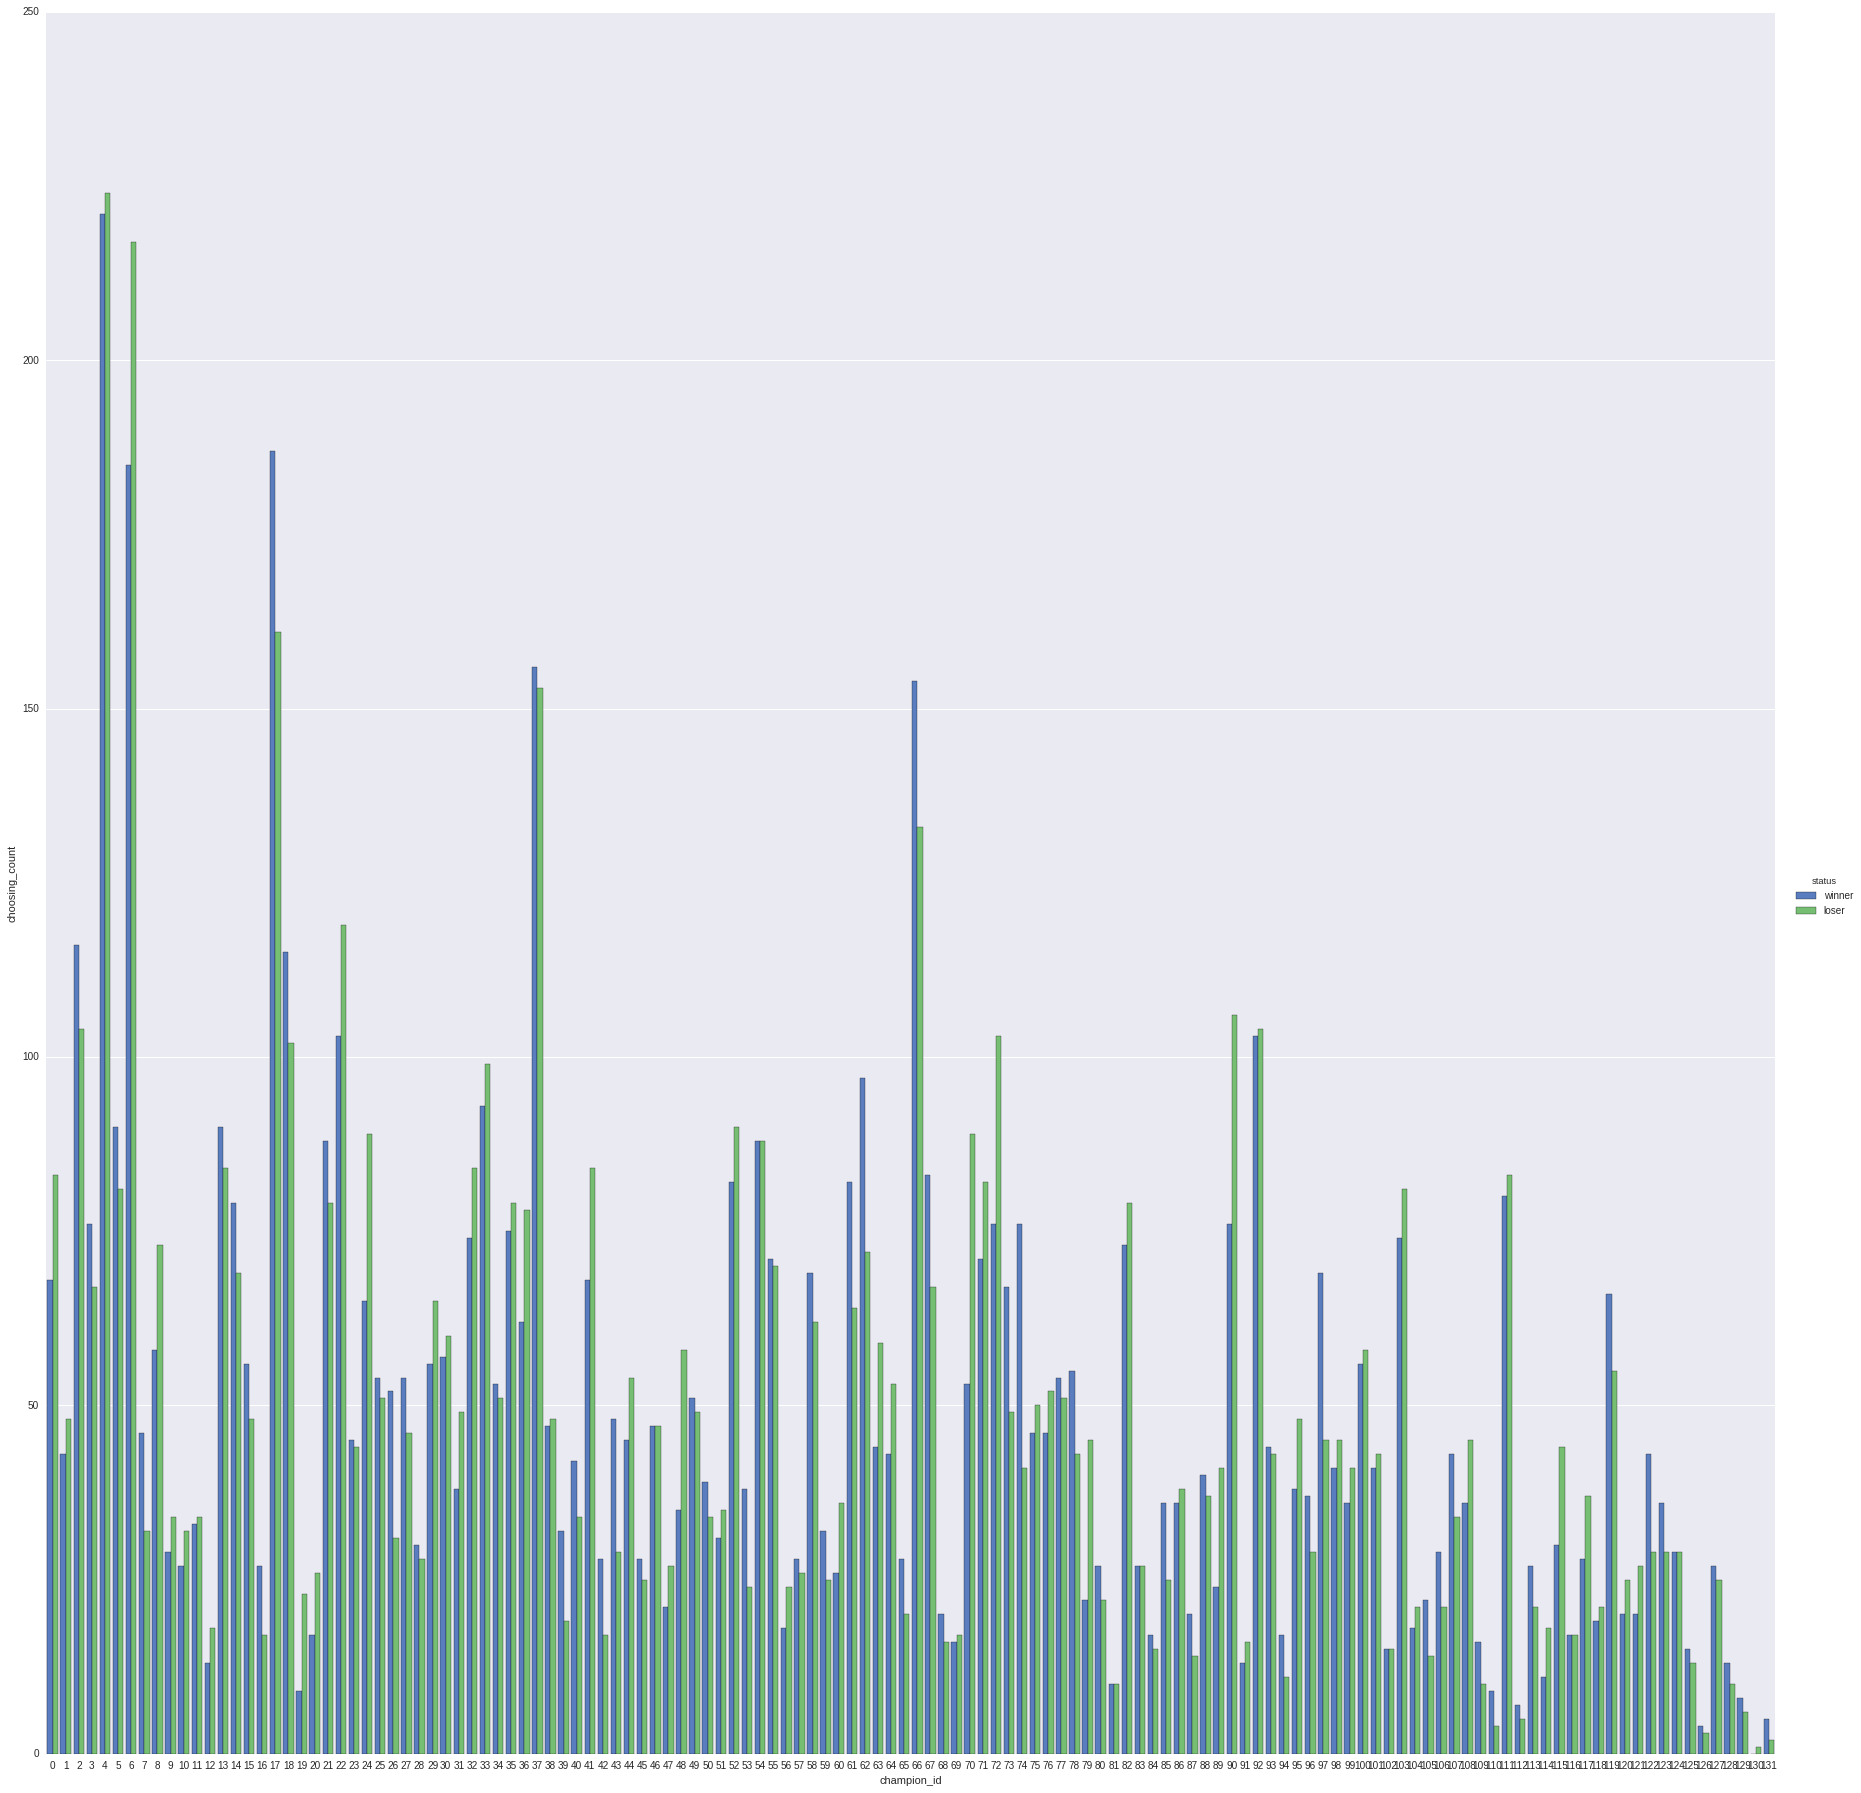

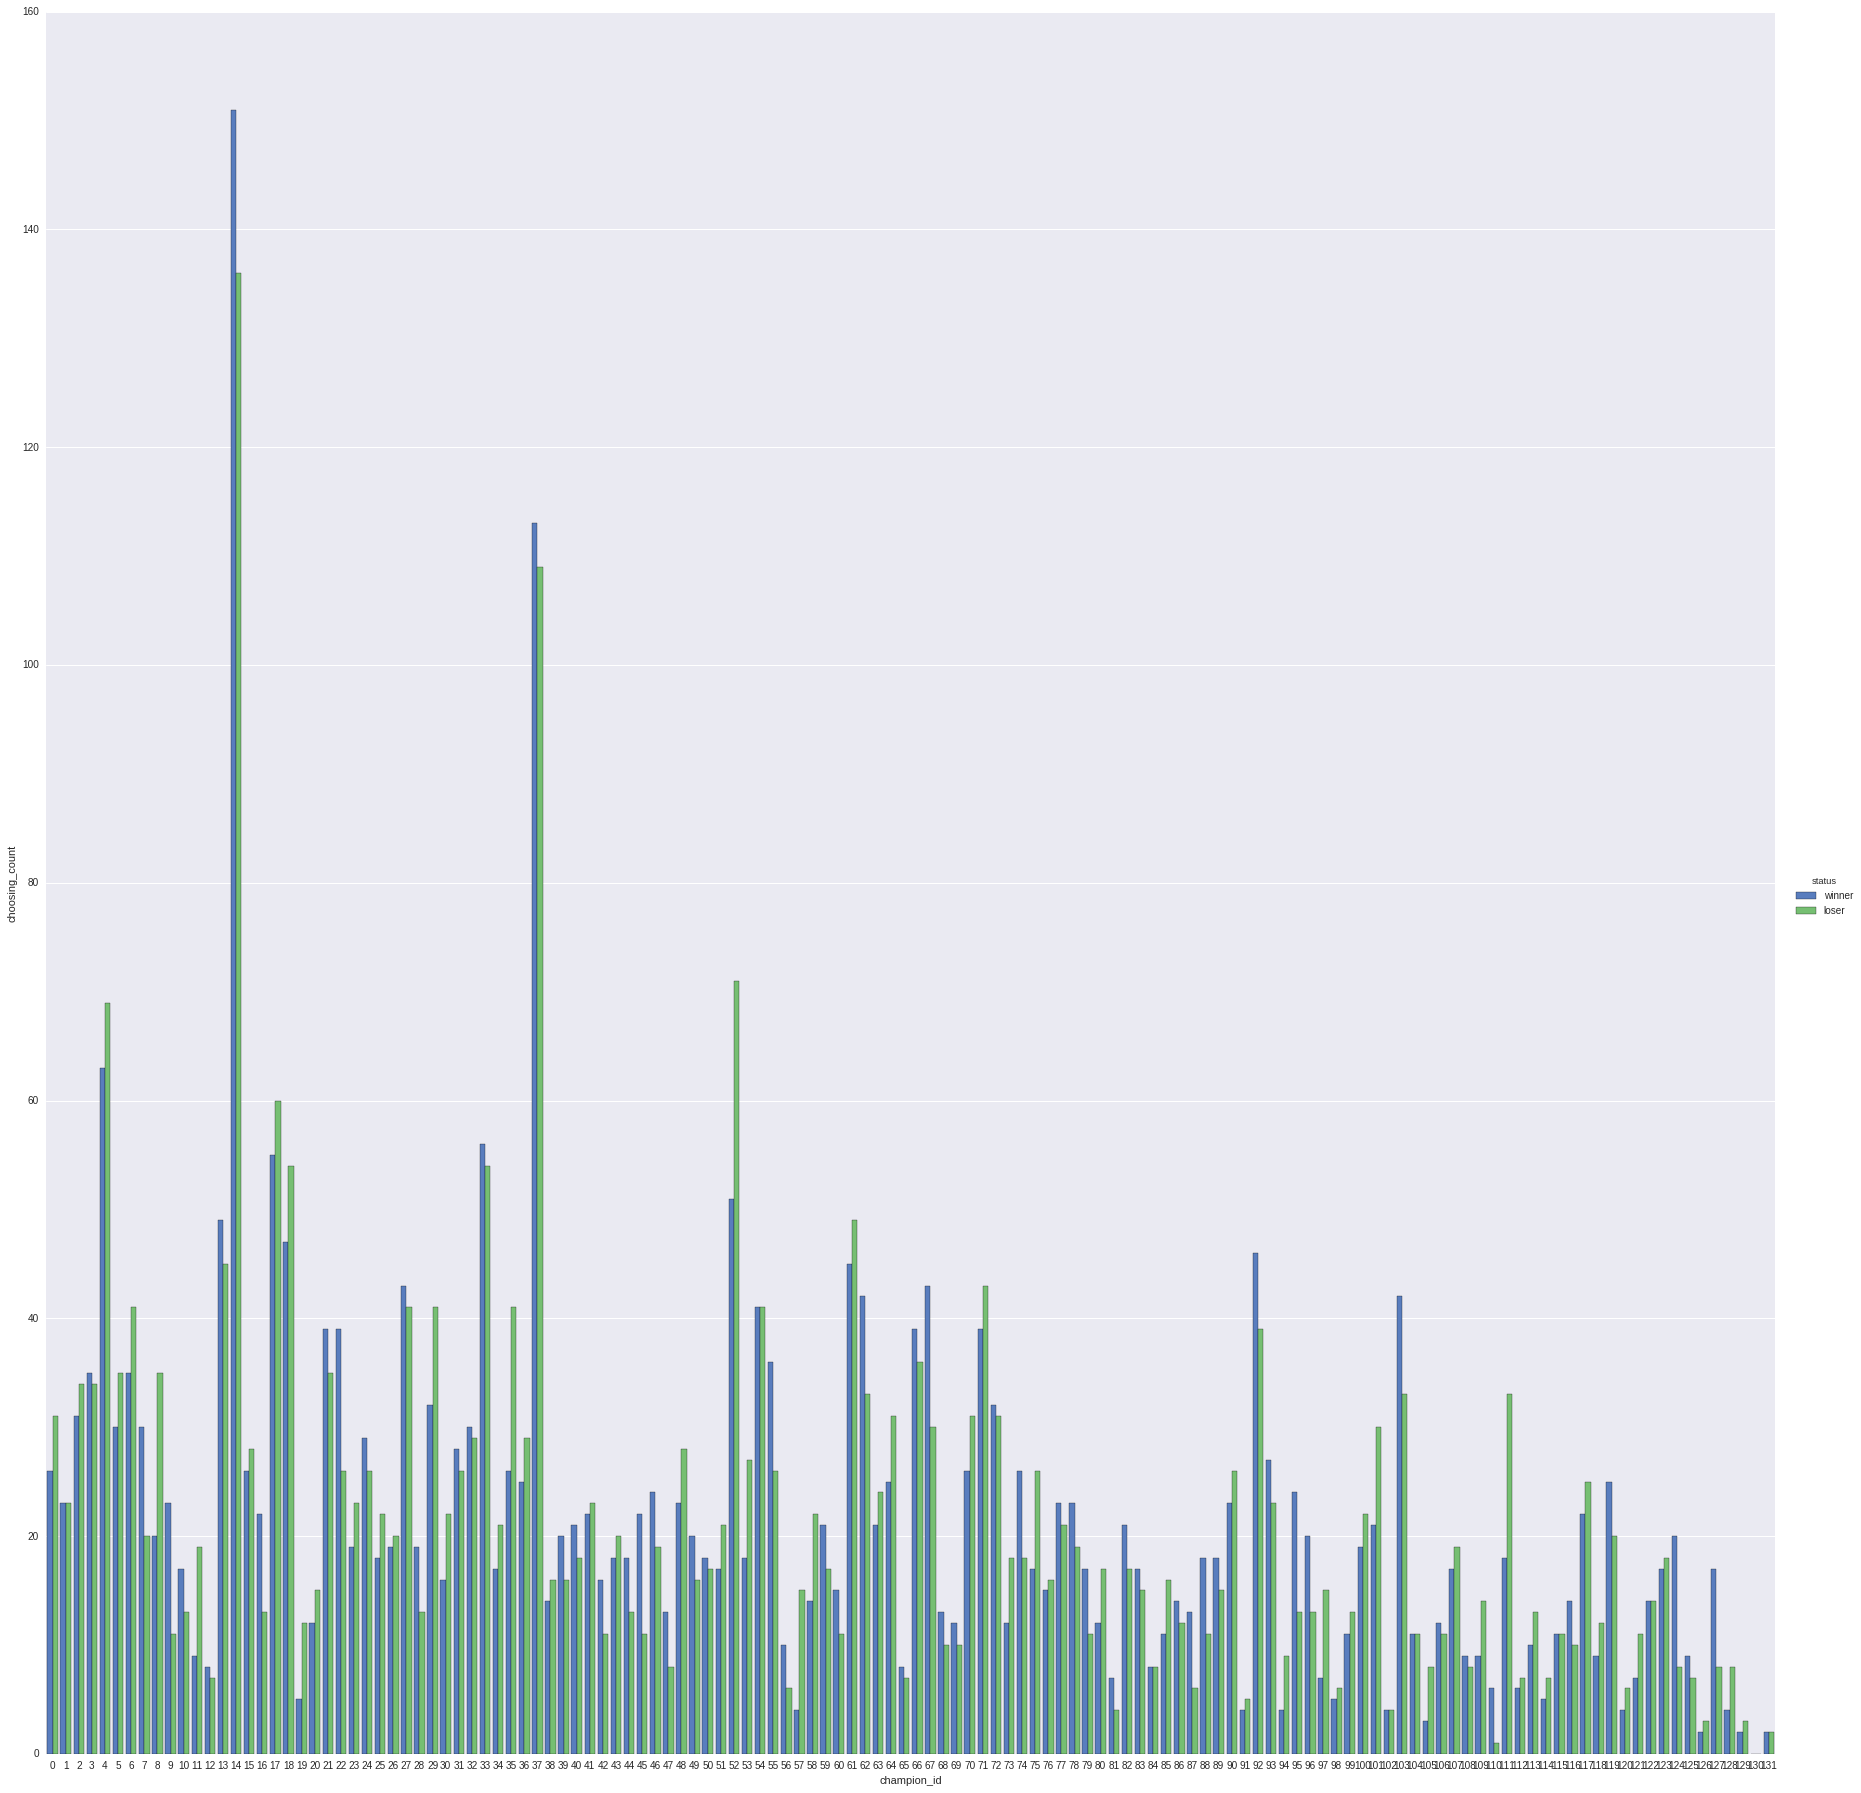

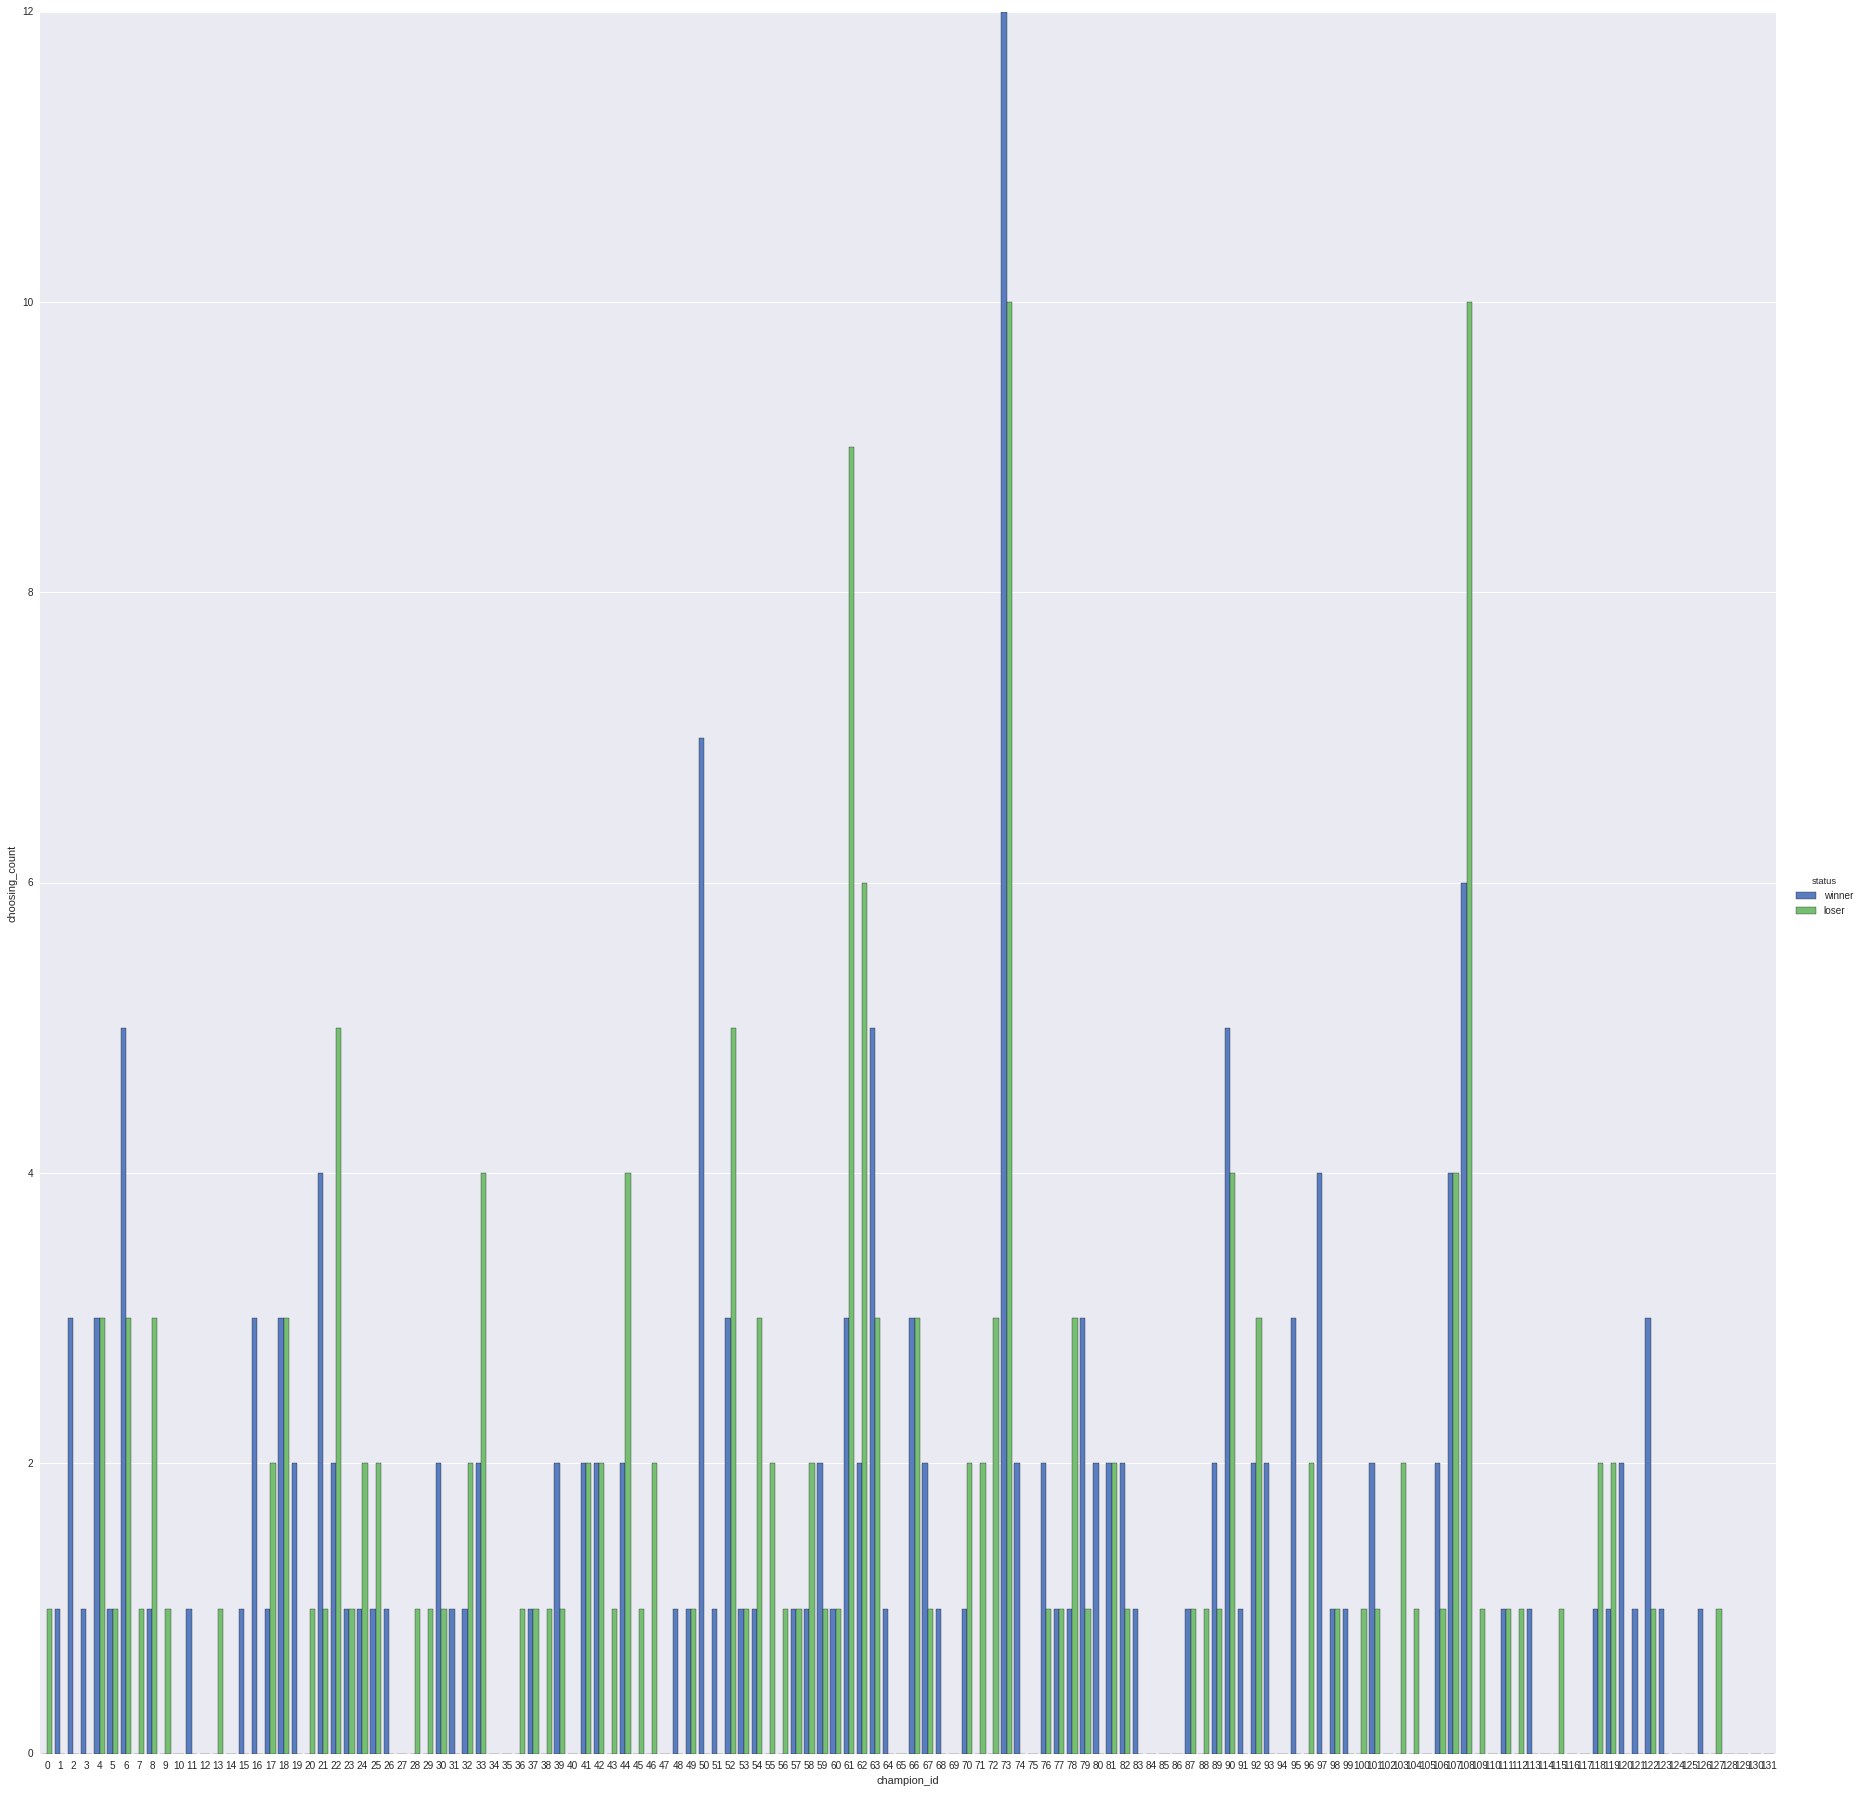

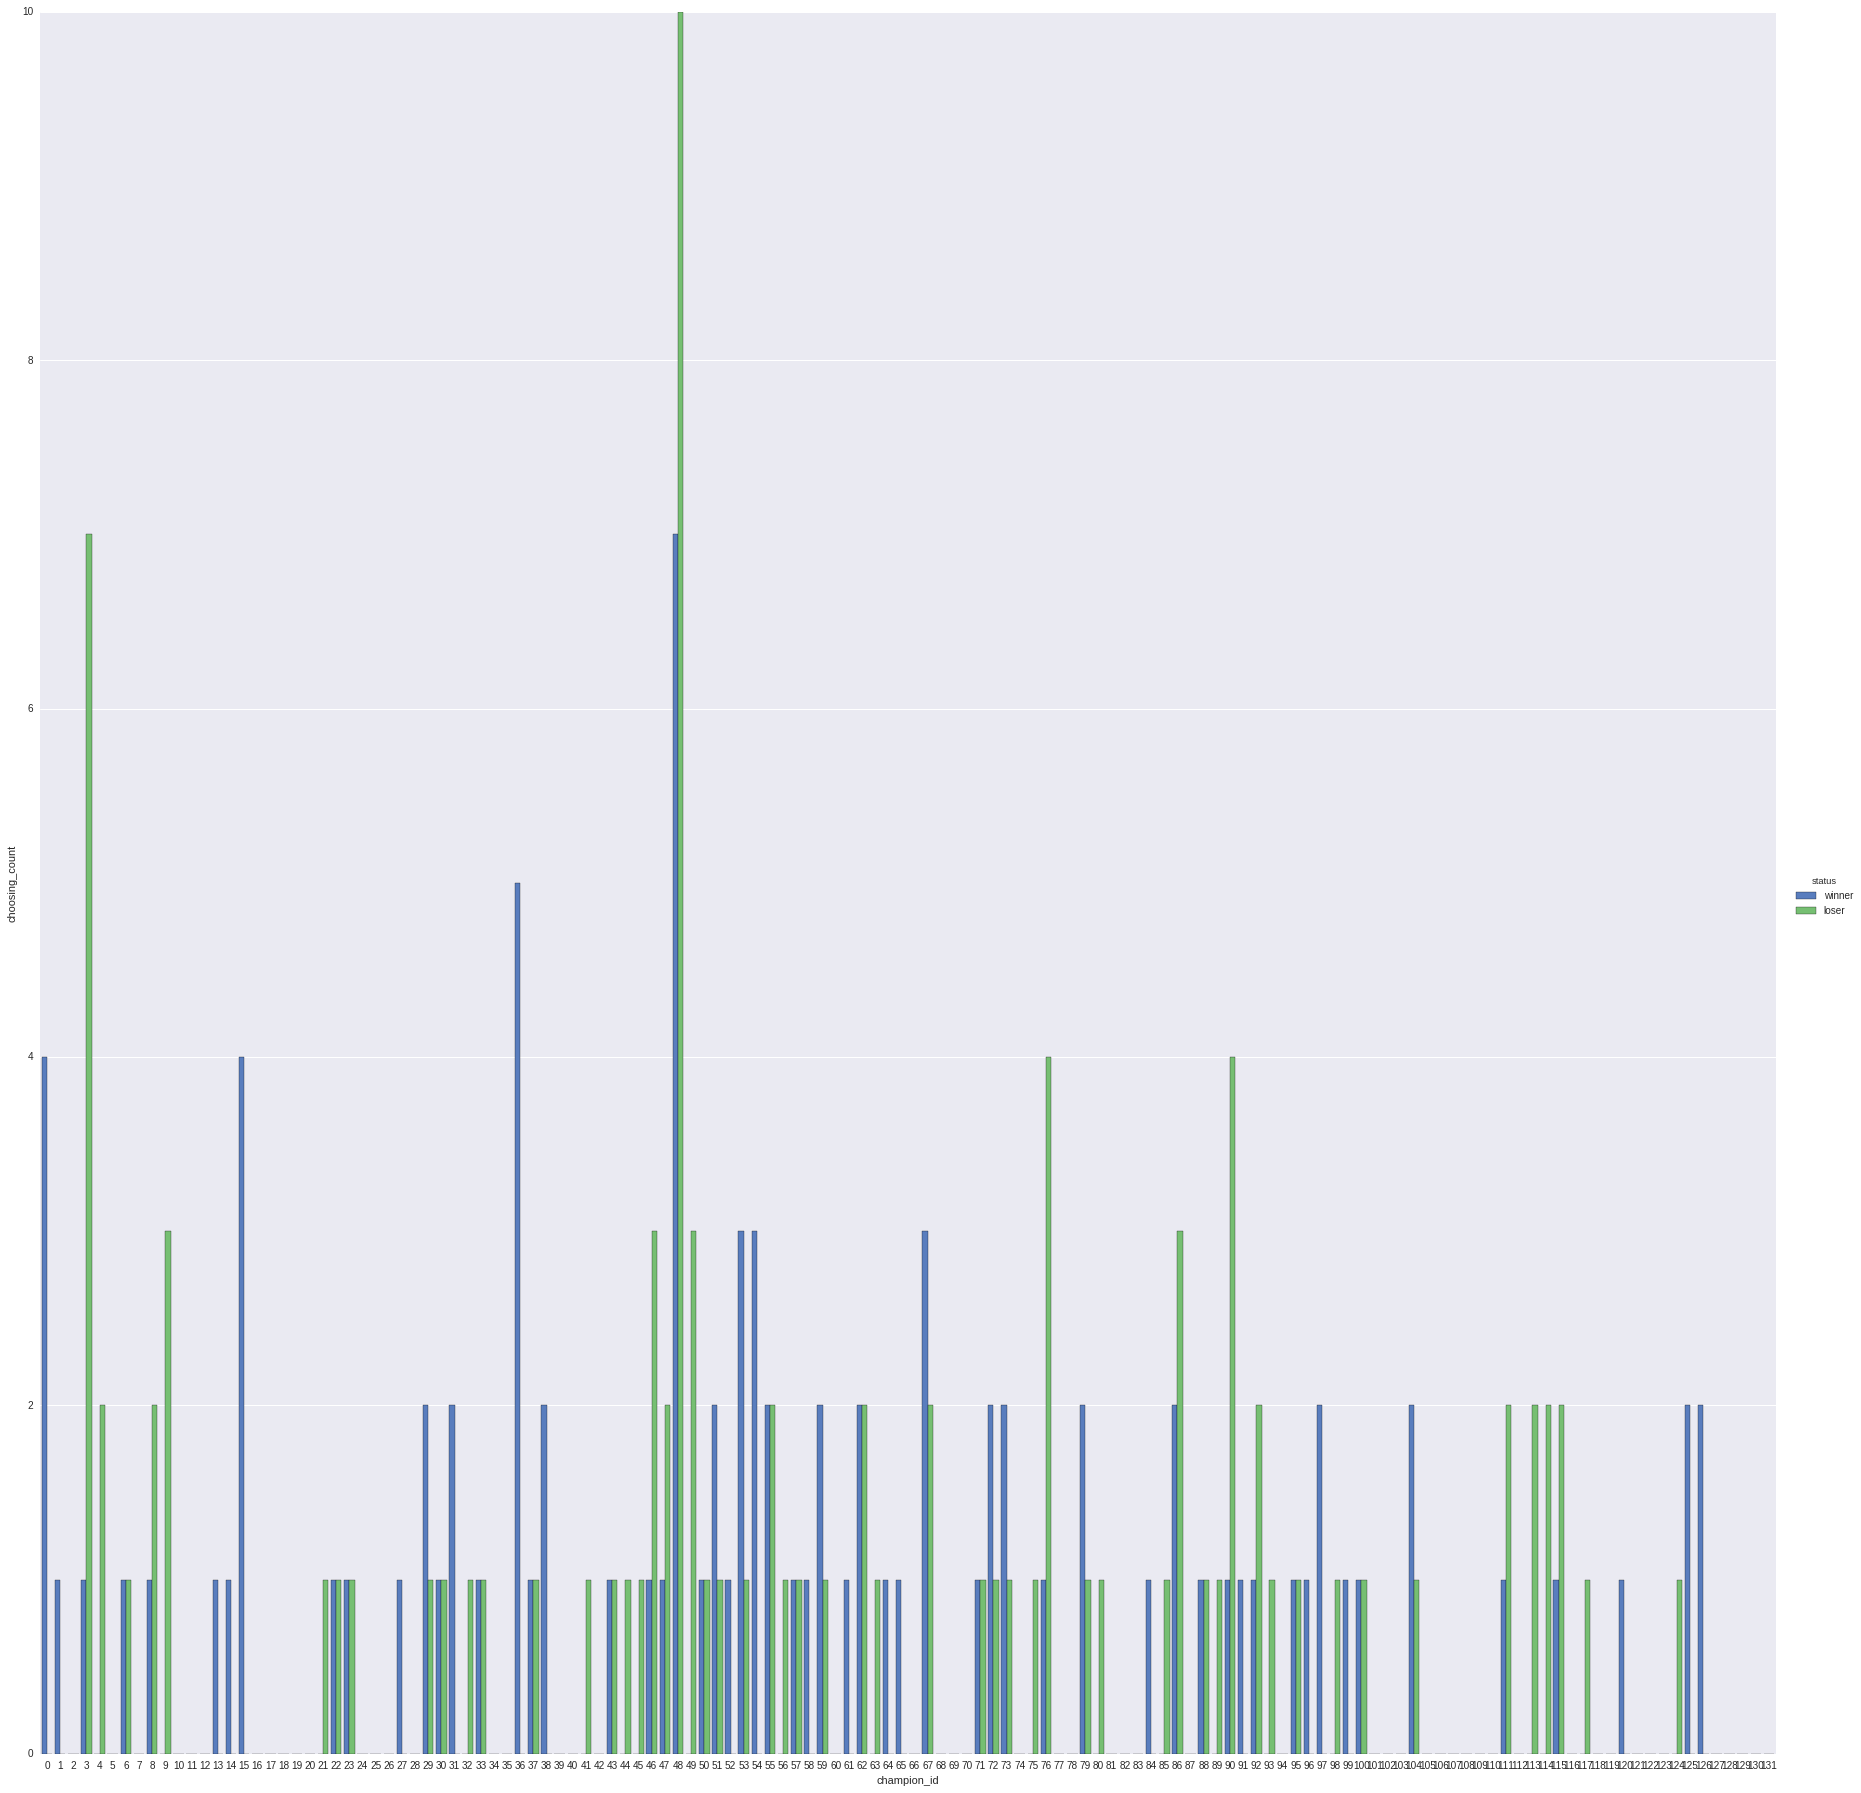

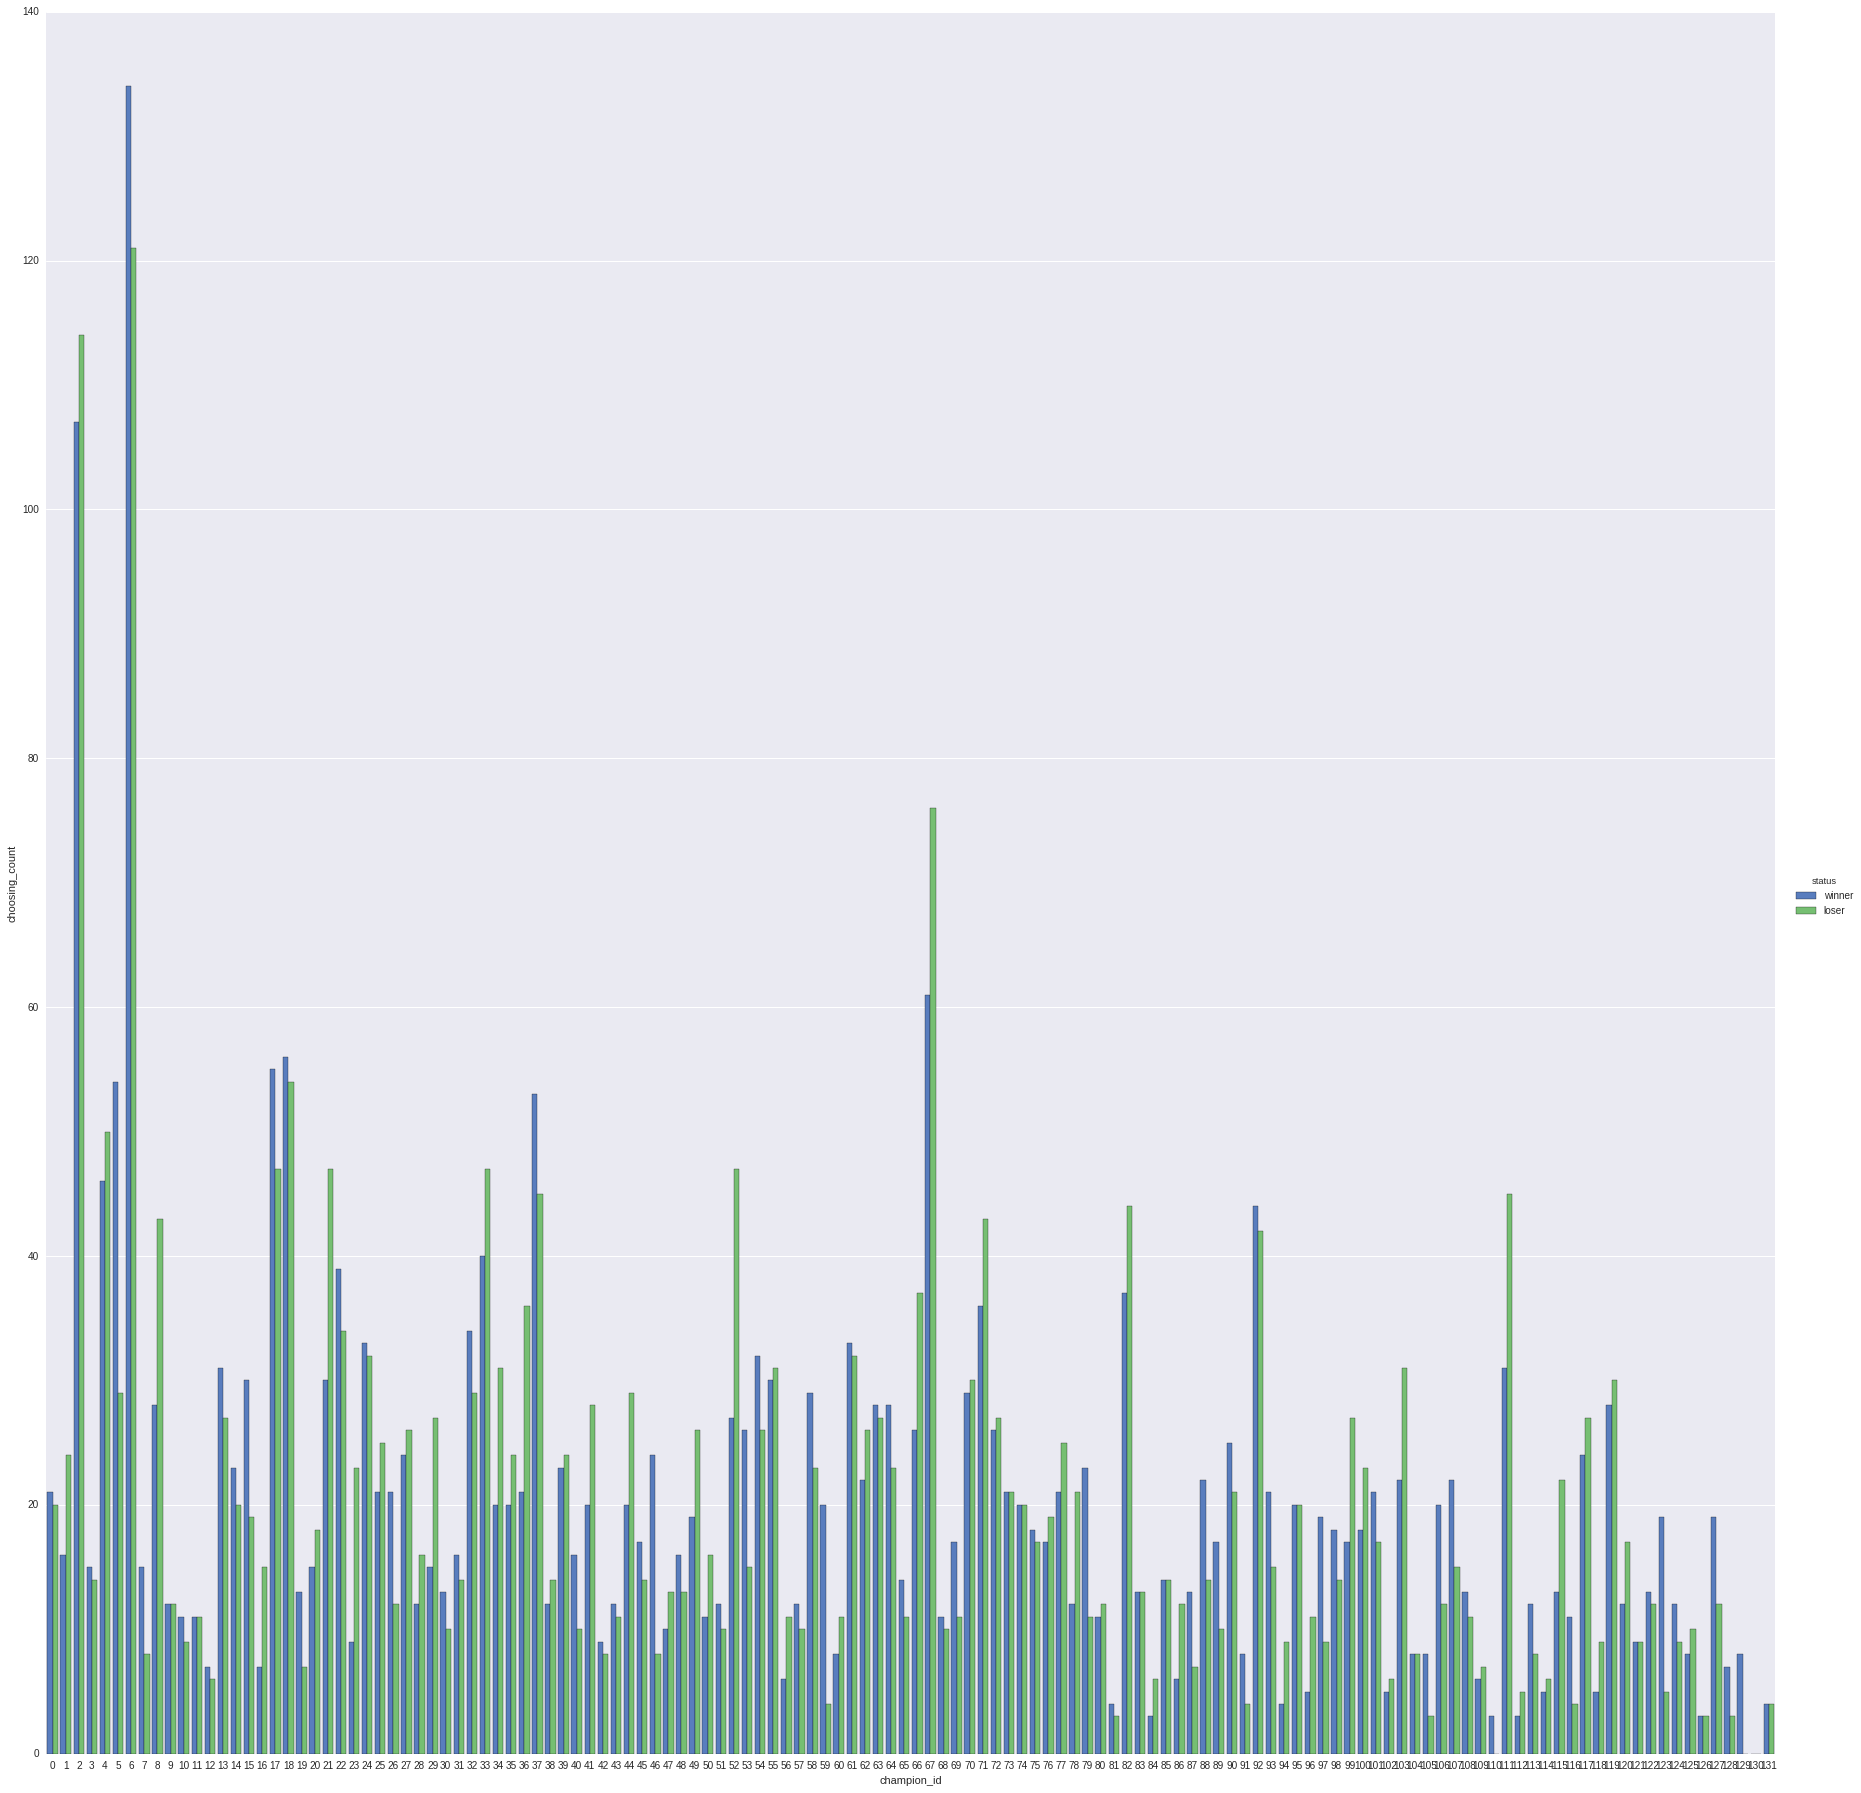

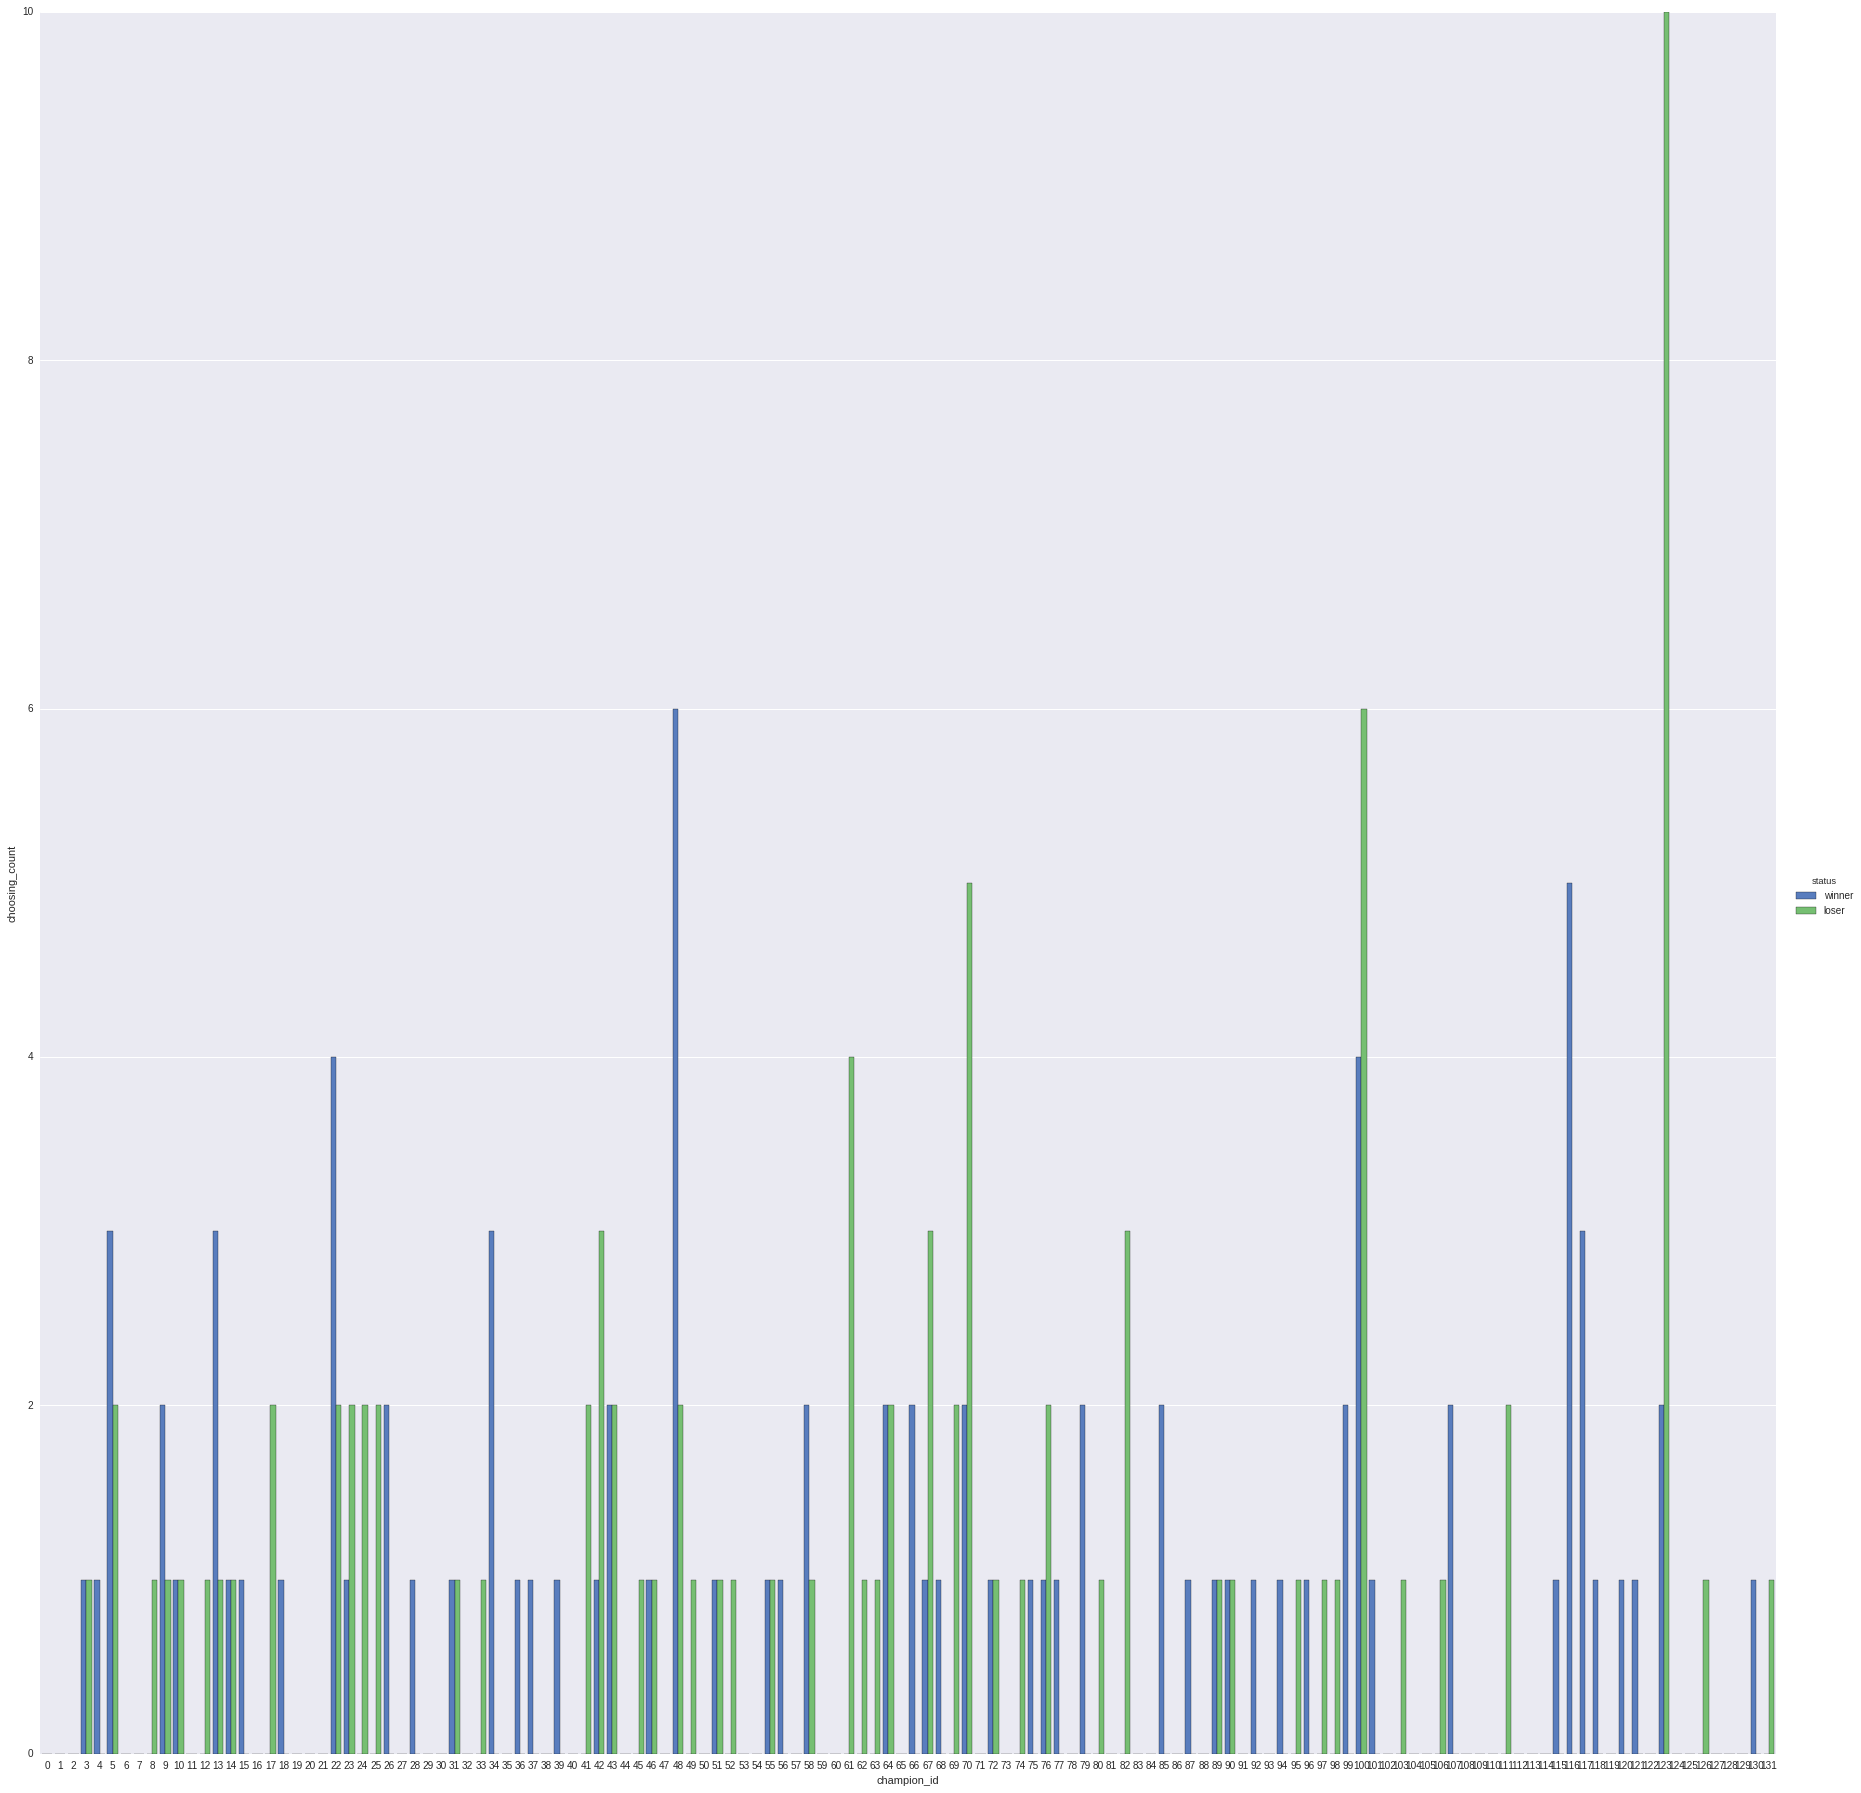

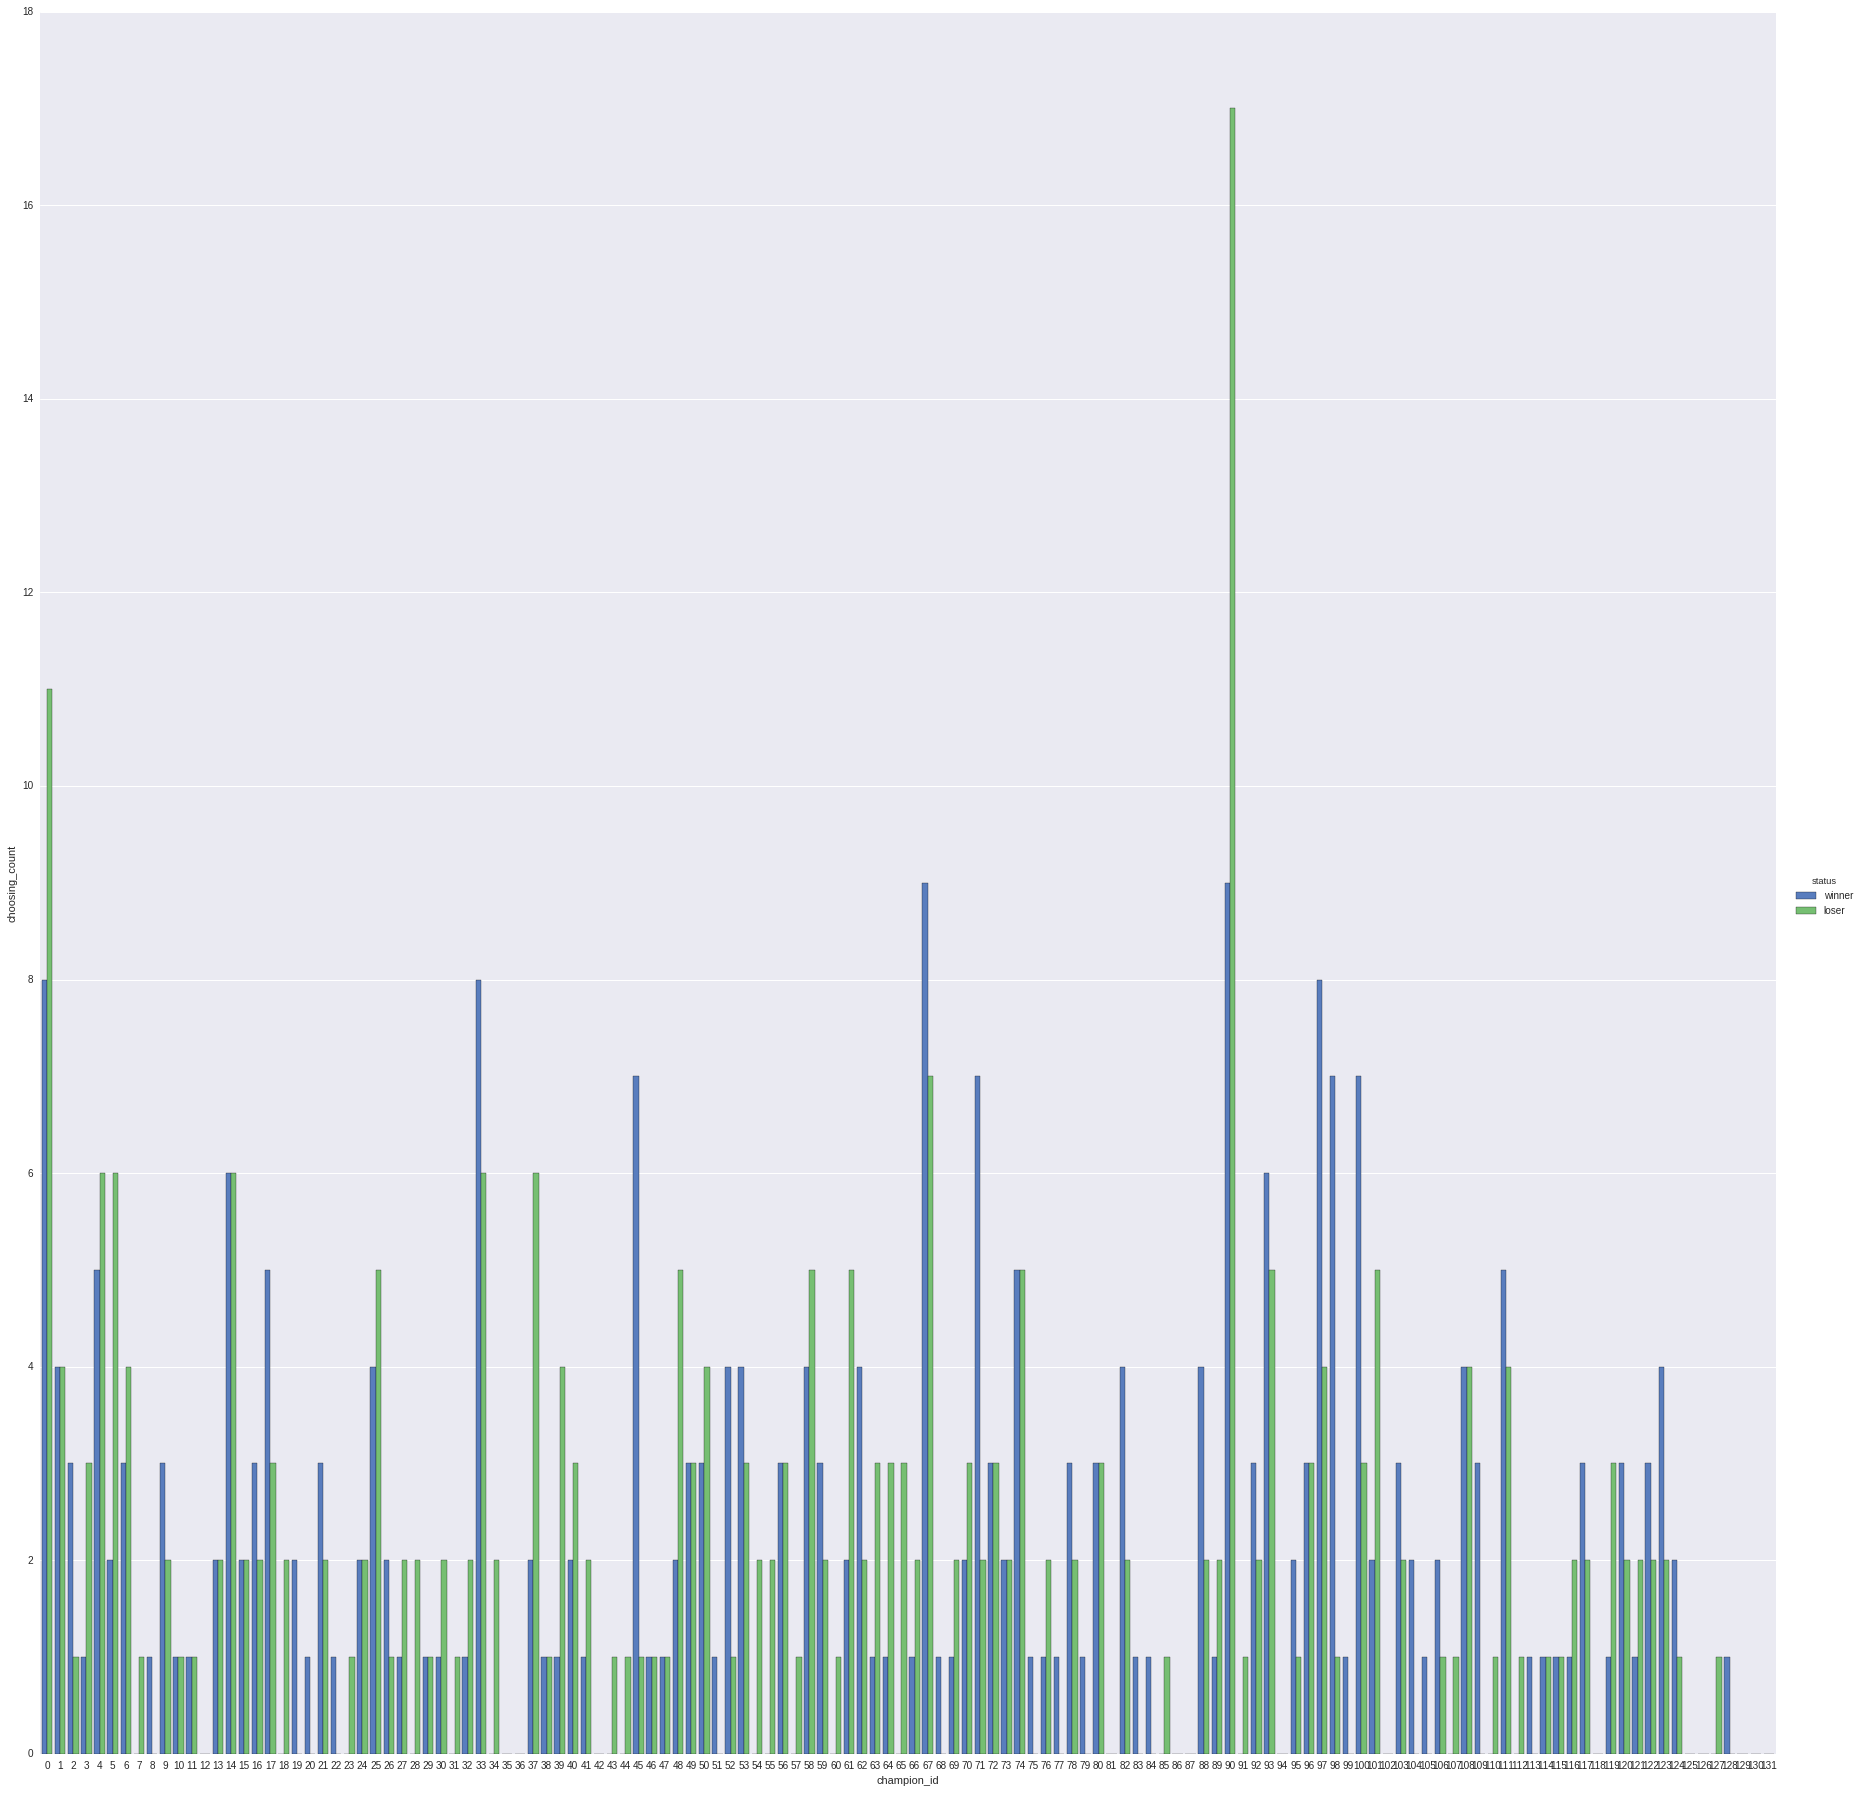

In [33]:
for i in range(9):
    print_one_cluster_champions(clustering, i)

# for good cluster

In [168]:
#good cluster to classify
idx = np.where(clustering.labels_==4)[0]
good_cluster_data = dataset_sampled.as_matrix()[idx,:]
accuracy = do_classification(good_cluster_data, verbose=False)
print(accuracy)
#winners = np.vstack((good_cluster_data[np.where(good_cluster_data[:,-1] == 1)[0],132:-1], good_cluster_data[np.where(good_cluster_data[:,-1] == 0)[0],:132]))
#losers = np.vstack((good_cluster_data[np.where(good_cluster_data[:,-1] == 1)[0],:132], good_cluster_data[np.where(good_cluster_data[:,-1] == 0)[0],132:-1]))

winners = [match[:132] if not match[-1] else match[132:-1] for match in good_cluster_data]
losers = [match[132:-1] if not match[-1] else match[:132] for match in good_cluster_data]

{'KNN': 46.666666666666664, 'Linear SVM': 68.333333333333329, 'Stochastic Gradient Descent Classifier': 39.166666666666657, 'Random Forest': 51.666666666666664, 'Linear Discriminant Analysis': 38.333333333333329, 'Naive Bayes': 44.999999999999993, 'Decision Tree': 64.166666666666657, 'Quadratic Discriminant Analysis': 62.499999999999993, 'Logistic Regression': 60.833333333333329, 'AdaBoost': 68.333333333333329, 'SVM with RBF kernel': 43.333333333333336}


In [185]:
print('Winners:')
for winner in winners:
    for champ_id in np.where(winner == 1)[0]:
        print(champions[champ_id]['tags'])
    print('\n')
print('\n\nLosers:')
for loser in losers:
    for champ_id in np.where(loser == 1)[0]:
        print(champions[champ_id]['tags'])
    print('\n')

Winners:
['Marksman']
['Fighter', 'Assassin']
['Assassin', 'Fighter']
['Fighter', 'Tank']
['Tank', 'Fighter']


['Fighter', 'Mage']
['Tank', 'Fighter']
['Fighter', 'Tank']
['Marksman', 'Support']
['Tank', 'Mage']


['Support', 'Mage']
['Assassin', 'Fighter']
['Marksman', 'Mage']
['Fighter', 'Assassin']
['Fighter']


['Support', 'Fighter']
['Fighter', 'Assassin']
['Tank', 'Fighter']
['Marksman']
['Mage']


['Support', 'Fighter']
['Fighter', 'Assassin']
['Fighter', 'Tank']
['Mage']
['Marksman']


['Tank', 'Fighter']
['Assassin', 'Fighter']
['Marksman', 'Mage']
['Marksman']
['Fighter', 'Tank']


['Mage', 'Support']
['Mage', 'Support']
['Marksman']
['Fighter', 'Tank']
['Fighter', 'Tank']


['Mage', 'Support']
['Tank', 'Fighter']
['Assassin', 'Fighter']
['Assassin', 'Fighter']
['Marksman']


['Mage', 'Support']
['Marksman', 'Mage']
['Tank', 'Fighter']
['Assassin', 'Fighter']
['Fighter', 'Tank']


['Mage', 'Support']
['Fighter', 'Tank']
['Tank', 'Fighter']
['Support', 'Mage']
['Marksman']




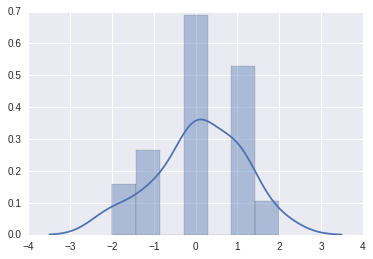

In [186]:
# Just champions' first category
diff = []
for i in range(len(good_cluster_data)):
#     diff.append(
#         len(set(chain.from_iterable([champions[champ_id]['tags'] for champ_id in np.where(winners[i] == 1)[0]])))
#         - len(set(chain.from_iterable([champions[champ_id]['tags'] for champ_id in np.where(losers[i] == 1)[0]])))
#         )
    diff.append(
        len(set([champions[champ_id]['tags'][0] for champ_id in np.where(winners[i] == 1)[0]]))
        - len(set([champions[champ_id]['tags'][0] for champ_id in np.where(losers[i] == 1)[0]]))
        )
sns.distplot(diff)

(array([  3.,   0.,   5.,   0.,   0.,  13.,   0.,  10.,   0.,   2.]),
 array([-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <a list of 10 Patch objects>)

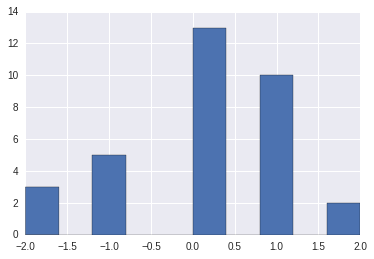

In [187]:
plt.hist(diff)

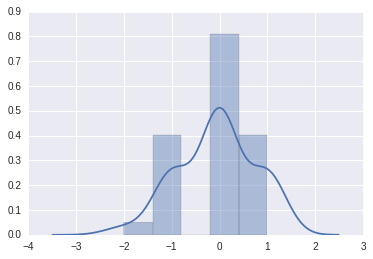

In [188]:
# both champions' categories
diff = []
for i in range(len(good_cluster_data)):
    diff.append(
        len(set(chain.from_iterable([champions[champ_id]['tags'] for champ_id in np.where(winners[i] == 1)[0]])))
        - len(set(chain.from_iterable([champions[champ_id]['tags'] for champ_id in np.where(losers[i] == 1)[0]])))
        )
sns.distplot(diff)

(array([  1.,   0.,   0.,   8.,   0.,   0.,  16.,   0.,   0.,   8.]),
 array([-2. , -1.7, -1.4, -1.1, -0.8, -0.5, -0.2,  0.1,  0.4,  0.7,  1. ]),
 <a list of 10 Patch objects>)

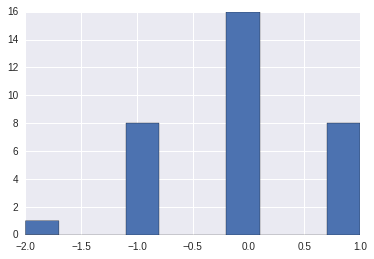

In [189]:
plt.hist(diff)

# diversity in terms of champion features

In [307]:
def plot_diversity(data, metric='euclidean'):
    winners = [match[:132] if not match[-1] else match[132:-1] for match in data]
    losers = [match[132:-1] if not match[-1] else match[:132] for match in data]
    winner_distance = [compute_average_distance([champions_stats_normalized[champ_id] for champ_id in np.where(winner == 1)[0]], metric=metric) for winner in winners]
    loser_distance = [compute_average_distance([champions_stats_normalized[champ_id] for champ_id in np.where(loser == 1)[0]], metric=metric) for loser in losers]

    plt.hist(winner_distance)
    plt.hist(loser_distance)
    plt.legend(['winners', 'losers'])
    plt.title(metric)
    plt.show()

In [308]:
def compute_average_distance(team, metric):
    return np.average(pdist(team, metric=metric))

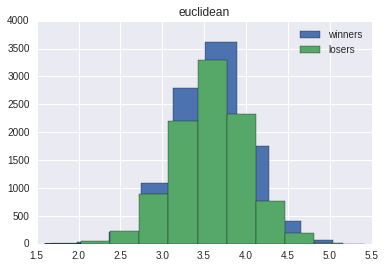

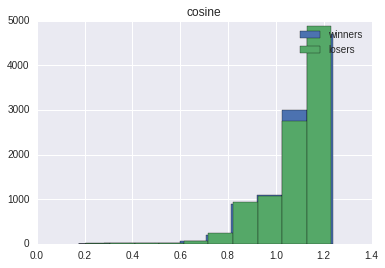

In [309]:
#for all data
plot_diversity(dataset.as_matrix(), metric='euclidean')
plot_diversity(dataset.as_matrix(), metric='cosine')

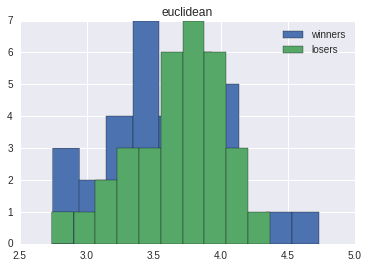

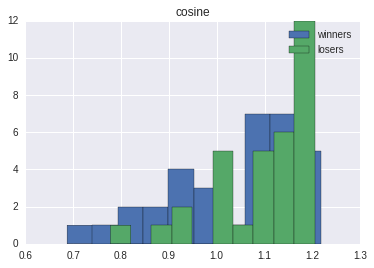

In [310]:
#good cluster to classify
idx = np.where(clustering.labels_==4)[0]
good_cluster_data = dataset_sampled.as_matrix()[idx,:]
plot_diversity(good_cluster_data, metric='euclidean')
plot_diversity(good_cluster_data, metric='cosine')